# EE 596 Mini Project 1 Final
Blake Downey and Ryan Maroney

## Stock Buy/Sell Prediction
In this mini-project - You will be working with real stock data pulled through the alpaca.markets api. We will provide you starter code below - So you can get started with using the API. You have about 2 weeks to work on this mini-project. Please get started early as identifying good strategies can take time. Good luck and have fun in the process!

## Logistics
Please work in groups of 2 - This is a requirement for this project. Your submission will include one submission of all the training code, back testing code, plots, requirements as outlined below + breakdown of contributions by each member of the project. Please make sure each member in your team tries out new trading strategies/algorithms and does coding as a way of contributing to the project. Also working in teams is a great way to brainstorm, collaborate and improve on your winning strategies.

In [1]:
%%capture
#!pip install backtrader
!pip install alpaca_trade_api
#!pip install matplotlib==3.2.2
#!pip install plotly
#!pip install prophet

In [3]:
import time 
from datetime import datetime, date, timedelta
import alpaca_trade_api as alpaca
from alpaca_trade_api.entity_v2 import BarsV2
#from prophet import Prophet
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import RidgeClassifier as LR_ridge
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import f1_score as f1
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers as L

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [4]:
ENDPOINT="https://paper-api.alpaca.markets"
API_KEY_ID="PKPZ2S22JEES07HVJWPE" # Put in yours here - Needed for paper trading
SECRET_KEY="WEXfJc7ohAd35AWHIKTMsu9RgKRqCpIbHVwWIvA5" # Put in yours here - Needed for paper trading

'''
Base Trading strategy class to be shared among strategies
'''
class TradingStrategy:
    def __init__(self, STOCK, DAYS):
        self.api = alpaca.REST(API_KEY_ID, SECRET_KEY, ENDPOINT)
        self.STOCK = STOCK
        self.SELL_LIMIT_FACTOR = 1.01 # 1 percent margin
        
        # Anything else you want to initialize or a method you want to
        # call during initialization of class - Feel free to add
        self.DAYS = DAYS
        self.get_bars()
        self.train_bars = None

        self.BACKTEST_START_MONEY = 10000.00
        self.backtest_money = self.BACKTEST_START_MONEY
        self.action_state = None
        self.actions = []
        self.current_num_stocks = 0
        self.current_stock_amount = 0.00

        # get the months and days of the stocks
        self.generate_date_stamps()

        self.hardcode_dates()
        
        # Get past 90 days closing prices
        #self.get_past90_closing_prices()

    def hardcode_dates(self):
      self.sell_earning_dates = {
          'AMZN' : (date(2022,2,2), date(2022,2,3)),
          'GOOGL' : (date(2022,1,31), date(2022,2,1)),
          'AAPL' : (date(2022,4,25), date(2022,4,26)),
          'NVDA' : (date(2022,5,23), date(2022,5,24)),
          'AMD' : (date(2022,2,1), date(2022,2,2))
      }

    def generate_date_stamps(self):
      dates_temp = self.bars['close'].index
      self.dates = []
      for i in range(len(dates_temp)):
        self.dates.append(dates_temp[i].date())

    def get_bars(self):
        self.bars = self.api.get_bars(self.STOCK, alpaca.TimeFrame.Day, date.today() - timedelta(days=self.DAYS), date.today() - timedelta(days=2), adjustment='raw').df
    
    def get_train_bars(self, percent_train=0.75):
        self.num_train_bars = int(len(self.bars)*percent_train)
        self.train_bars = self.bars.iloc[:self.num_train_bars,:]
        self.future_bars = self.bars.iloc[self.num_train_bars:,:]

    def get_past90_closing_prices(self):  
        barset = self.api.get_barset(self.STOCK, 'day', limit=90)
        bars = barset[self.STOCK]
        self.past90_closing_prices = [bars[index].c for index in range(len(bars))]
    
    def get_current_price(self):
        return float(self.api.get_last_trade(self.STOCK).price)
    
    def get_quantity_buy(self):
        if int(float(self.api.get_account().cash)) > 0:
            return int((float(self.api.get_account().cash)/2) \
                       /self.get_current_price())
        else:
            return 0

    def get_sell_quantity(self):
        positions=self.api.list_positions()
        for position in positions:
            if position.symbol==self.STOCK:
                return int(position.qty)
        return 0
        
    def exists_buy_order(self):
        # Identifies if a buy order exists for a stock
        orders = self.api.list_orders()
        for order in orders:
            if order.side=="buy" and order.symbol==self.STOCK:
                return True
        
        return False
    
    def have_bought_stock(self):
        positions=self.api.list_positions()
        for position in positions:
            if position.symbol==self.STOCK and int(position.qty)==self.NEW_QUANTITY + self.EXISTING_QUANTITY:
                return True
        return False
        
        
    def get_buy_price(self):
        # Identify the buying price for a stock
        positions=self.api.list_positions()
        for position in positions:
            if position.symbol==self.STOCK:
                return float(position.cost_basis)/int(position.qty)
    
    
    def buy_market_order(self):
        # Buy the stock at market price (This is for paper-trading)
        if self.NEW_QUANTITY > 0:
            self.api.submit_order(self.STOCK, \
                        qty=self.NEW_QUANTITY,\
                        side="buy",\
                        type="market", \
                        time_in_force="day",
                        order_class=None)
        
    def buy_limit_order(self,base_price):
        if self.NEW_QUANTITY > 0:
            self.api.submit_order(self.STOCK, \
                        qty=self.NEW_QUANTITY,\
                        side="buy",\
                        type="limit", \
                        limit_price=base_price, \
                        time_in_force="day",
                        order_class=None)
        
    def sell_market_order(self):
        if self.get_sell_quantity() > 0: # if there are more than 0 qty 
            self.api.submit_order(self.STOCK, \
                        qty=self.get_sell_quantity(),\
                        side="sell",\
                        type="market",\
                        time_in_force="day",
                        order_class=None)

    def sell_limit_order(self):
        if self.get_sell_quantity() > 0:
            self.api.submit_order(self.STOCK, \
                        qty=self.get_sell_quantity(),\
                        side="sell",\
                        type="limit", \
                        limit_price=self.SELL_LIMIT_PRICE, \
                        time_in_force="day",
                        order_class=None)
        
    def identify_strategy_for_selling(self):
        # If you have multiple strategies
        # Pick between them here - Or use ML to help identify 
        # your strategy
        pass
        
    def market_buy_strategy(self):
        # Providing a simple trading strategy here:
        # Buy at market price if conditions are favorable for buying
        # Sell at a limit price that is determined based on buying price
        # This strategy doesn't use any ML here - You may want to use
        # appropriate libraries to train models + use the trained strategy 
        # here
        
        # Get existing quantity
        positions = self.api.list_positions()
        self.EXISTING_QUANTITY = 0
        for position in positions:
            if position.symbol == self.STOCK:
                self.EXISTING_QUANTITY += int(position.qty)
                
        # MARKET BUY order
        self.NEW_QUANTITY=self.get_quantity_buy()
        
        if self.NEW_QUANTITY == 0:
            return "ZERO EQUITY"
        
        if not self.exists_buy_order():
            self.buy_market_order()
            
        
        # BRACKET SELL order
        # Initiate sell order if stock has been bought
        # If not, wait for it to be bought
        while not self.have_bought_stock():
            #print(self.api.positions)
            #print(self.NEW_QUANTITY + self.EXISTING_QUANTITY)
            time.sleep(1)
        
        if self.have_bought_stock():
            buy_price=self.get_buy_price()
            self.SELL_LIMIT_PRICE=int(float(buy_price))*self.SELL_LIMIT_FACTOR
            
            # Initiate Sell order
            self.sell_limit_order()
      
    def your_best_strategy(self):
        # Implement here or add other methods to do the same
        pass
       
    '''
    ''' 
    def preprocess_strategy(self):
      # Implement in child class
      pass

    '''
    '''
    def execute_strategy(self, current_price):
      # Implement in child class
      pass

    '''
    Backtest evaluation, buy max of 1 stock, sell all stocks on sell
    '''
    def execute_backtest_trade(self, action, price):
      if action == "BUY":
        if self.current_num_stocks < 1:
          self.action_state = "BUY"
          self.backtest_money -= price
          self.current_num_stocks += 1

      elif action == "SELL":
        if self.current_num_stocks > 0:
          self.action_state = "SELL"
          self.backtest_money += self.current_num_stocks * price
          self.current_num_stocks = 0

      else: # hold current position
        pass

    '''
    execute paper trade
    '''
    def execute_trade(self, action):
      if action == "BUY":
        self.NEW_QUANTITY = self.get_quantity_buy()
        
        if self.NEW_QUANTITY == 0:
          print("ZERO EQUITY")
        else:
          self.buy_market_order()

      elif action == "SELL":
        if self.have_bought_stock():
          print("sell")
          buy_price=self.get_buy_price()
          self.SELL_LIMIT_PRICE=int(float(buy_price))*self.SELL_LIMIT_FACTOR
          
          # Initiate Sell order
          self.sell_limit_order()

      else: # hold current position
        pass

    '''
    Use bars to execute strategy rather than list of prices
    '''
    def run_backtest_bars(self, percent_train=0.75):
      self.backtest_money = self.BACKTEST_START_MONEY

      self.actions = []

      self.get_train_bars(percent_train)
      self.preprocess_strategy(self.train_bars)

      for index, future_bar in self.future_bars.iterrows():
        action = self.execute_strategy(self.train_bars, future_bar['close'], is_backtest=True)

        # Sell before earnings dates
        if index == self.sell_earning_dates[self.STOCK][0]:
          action = 'SELL'

        self.actions.append(action)
        self.train_bars = self.train_bars.append(future_bar)
        self.execute_backtest_trade(action, future_bar['close'])

      self.execute_backtest_trade("SELL", self.future_bars.iloc[-1]['close'])

      return self.actions, self.backtest_money
        

    '''
    run backtest with list of prices
    '''
    def run_backtest(self, percent_train=0.4):
      prices = self.bars['close'].values
      train_days = int(len(prices)*(percent_train))
      train_prices = prices[:train_days]
      future_prices = prices[train_days:]

      
      dates = self.bars['close'].index
      future_dates = dates[train_days:]

      self.backtest_money = self.BACKTEST_START_MONEY
      self.actions = []

      self.preprocess_strategy(train_prices)

      for i,price in enumerate(future_prices):
        action = self.execute_strategy(price)

        if future_dates[i] == self.sell_earning_dates[self.STOCK][0]:
          action = 'SELL'

        self.actions.append(action)
        self.execute_backtest_trade(action, price)

      self.execute_backtest_trade("SELL", future_prices[-1])

      return self.actions, self.backtest_money

    '''
    plot backtest results
    '''
    def plot_backtest_trades(self):
      prices = self.bars['close'].tail(len(self.actions)).values

      plt.figure(figsize=(10,10))
      plt.title(f"Backtest Trading {self.STOCK} (Percent Profits: {100.0*(self.backtest_money - self.BACKTEST_START_MONEY) / self.BACKTEST_START_MONEY})")
      plt.plot(prices)

      for i, action in enumerate(self.actions):
        if action == "BUY":
          plt.plot(i, prices[i], marker='^', markersize=15, markeredgecolor="green", markerfacecolor="green")
        elif action == "SELL":
          plt.plot(i, prices[i], marker='v', markersize=15, markeredgecolor="red", markerfacecolor="red")

      plt.show()

    '''
    run live trading
    '''
    def run_live_paper_strategy(self):
      
      self.preprocess_strategy() # Maybe not needed?
      current_price = self.get_current_price()
      action = self.execute_strategy(current_price)
      print(current_price, action)
      self.execute_trade(action)
 

In [5]:
'''
Base moving average class
'''
class MovingAverage:
  '''
  '''
  def __init__(self, values):
    self.mean = 0

  '''
  '''
  def calculate_average(self, values):
    pass

  '''
  '''
  def update_average(self, new_data_point):
    pass

'''
Simple moving average taking average of last n days
'''
class SimpleMovingAverage(MovingAverage):
  '''
  '''
  def __init__(self, values, period):
    self.period = period
    super().__init__(values)
    self.calculate_average(values)

  '''
  '''
  def calculate_average(self, values):
    self.values = values[len(values) - self.period:]
    self.mean = self.values.mean()

  '''
  '''
  def update_average(self, new_data_point):
    self.values = np.append(self.values, new_data_point)[1:]
    self.mean = self.values.mean()

'''
Exponential moving average weight most recent day base on beta value
'''
class ExponentialMovingAverage(MovingAverage):
  '''
  '''
  def __init__(self, values, beta=0.3):
    super().__init__(values)
    self.beta = beta
    self.calculate_average(values)

  '''
  '''
  def calculate_average(self, values):
    self.mean = 0

    for i in range(len(values)):
      self.mean += (values[i] + self.mean) * ((1-self.beta)**(len(values) - 1 - i))
      self.mean *= self.beta

  '''
  '''
  def update_average(self, new_data_point):
    self.mean *= 1 - self.beta
    self.mean += self.beta * new_data_point

'''
Baseline crossover strategy comparing when two moving averages crossover
'''
class BaselineCrossoverStrategy(TradingStrategy):
  '''
  '''
  def __init__(self, STOCK, DAYS, fast_method="SMA", slow_method="SMA", sma_fast_period=5, sma_slow_period=20, ema_fast_beta=0.5, ema_slow_beta=0.5):
    super().__init__(STOCK, DAYS)

    if fast_method == "SMA":
      self.fast_method = SimpleMovingAverage(self.bars['close'].values, sma_fast_period)
    elif fast_method == "EMA":
      self.fast_method = ExponentialMovingAverage(self.bars['close'].values, ema_fast_beta)

    if slow_method == "SMA":
      self.slow_method = SimpleMovingAverage(self.bars['close'].values, sma_slow_period)
    elif slow_method == "EMA":
      self.slow_method = ExponentialMovingAverage(self.bars['close'].values, ema_slow_beta)

    self.crossover_state = self.get_crossover_state()

  '''
  '''
  def get_crossover_state(self):
    return self.fast_method.mean > self.slow_method.mean
      
  '''
  '''
  def preprocess_strategy(self, data=None):
    if not isinstance(data, type(None)):
      self.fast_method.calculate_average(data)
      self.slow_method.calculate_average(data)

    self.crossover_state = self.get_crossover_state()

  '''
  '''
  def execute_strategy(self, current_price):
    action = None

    self.fast_method.update_average(current_price)
    self.slow_method.update_average(current_price)

    new_state = self.get_crossover_state()

    if self.crossover_state and not new_state:
      action = "SELL"
    elif not self.crossover_state and new_state:
      action = "BUY"

    self.crossover_state = new_state

    return action

  def generate_fast_slow(self):
    slow, fast = [], []

    for i, price in enumerate(self.bars['close'].values):

        self.fast_method.update_average(price)
        self.slow_method.update_average(price)
        fast.append(self.fast_method.mean)
        slow.append(self.slow_method.mean)

    return fast, slow

In [ ]:
STOCKS = ['AMZN', 'GOOGL', 'AAPL', 'NVDA', 'AMD']
DAYS = 365
PERCENT_TRAIN = 7.0/12.0
columns = STOCKS + ['Total']
index = ['SmaCross', 'EmaSmaCross', 'EmaCross', 'STL', 'ML-LR', 'DNN']
profit_totals = pd.DataFrame(columns=columns, index=index)
profit_percentages = pd.DataFrame(columns=columns, index=index)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:272: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.


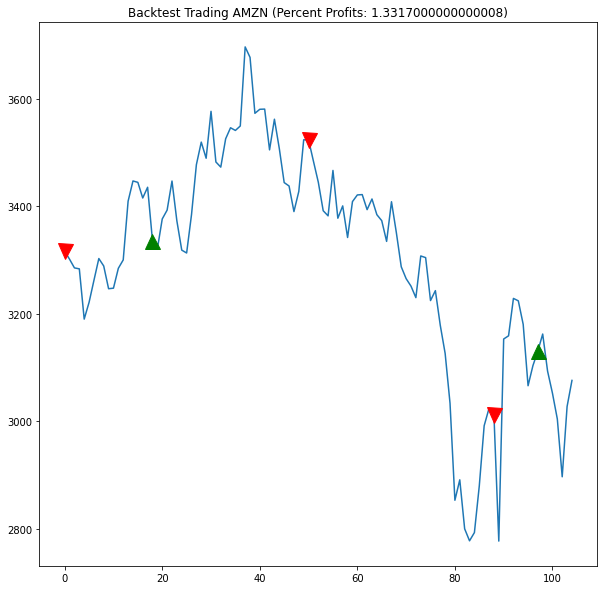

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:272: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.


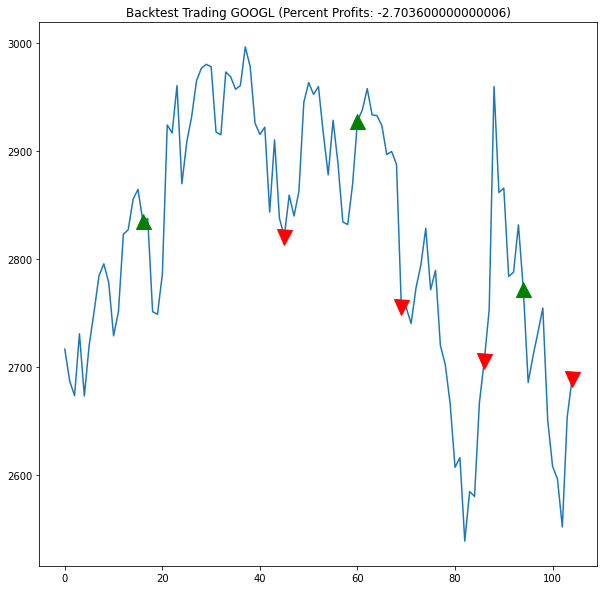

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:272: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.


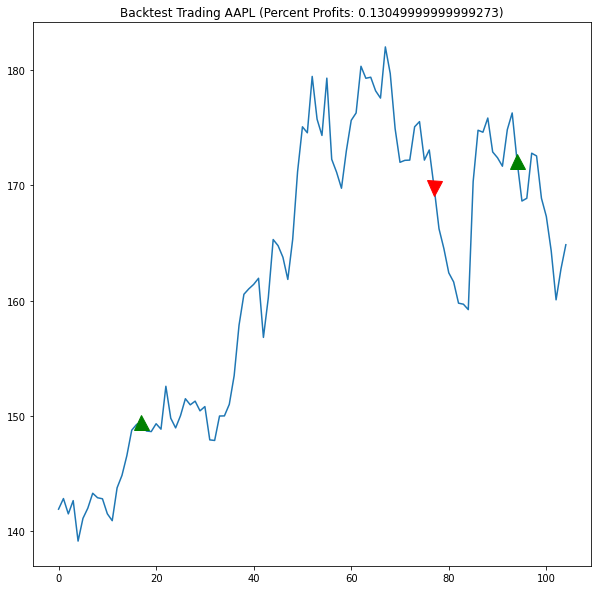

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:272: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.


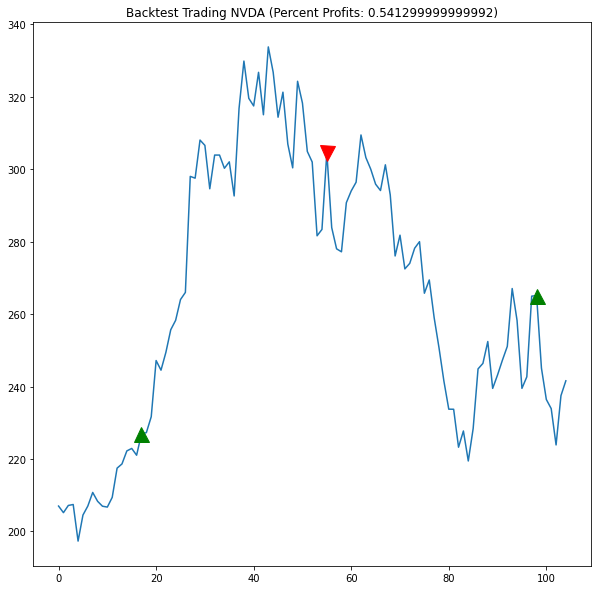

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:272: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.


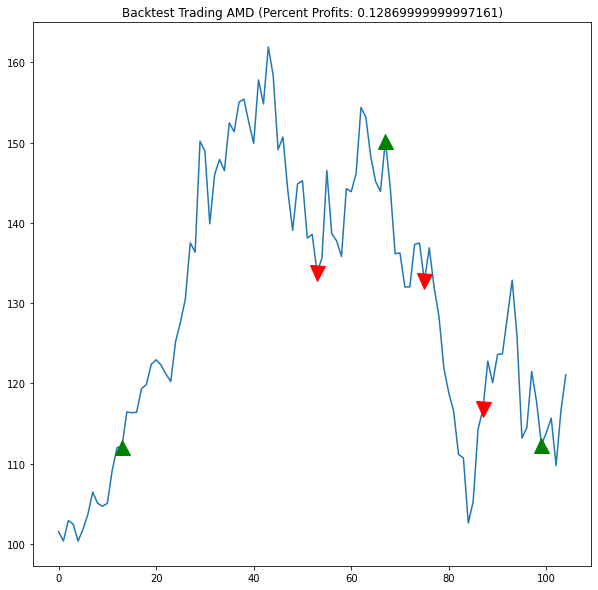

In [ ]:
sma_cross_strategies = {}
total_start = 0
total_end = 0

for stock in STOCKS:
  sma_cross_strategies[stock] = BaselineCrossoverStrategy(stock, DAYS,
                                                fast_method="SMA", 
                                                slow_method="SMA", 
                                                sma_fast_period=13, 
                                                sma_slow_period=25)
  
  actions, ending_money = sma_cross_strategies[stock].run_backtest(PERCENT_TRAIN)

  sma_cross_strategies[stock].plot_backtest_trades()

  total_start += sma_cross_strategies[stock].BACKTEST_START_MONEY
  total_end += sma_cross_strategies[stock].backtest_money

  profit_percentages.loc['SmaCross',stock] = "{:.2f}%".format(100*(sma_cross_strategies[stock].backtest_money - sma_cross_strategies[stock].BACKTEST_START_MONEY) / sma_cross_strategies[stock].BACKTEST_START_MONEY)
  profit_totals.loc['SmaCross',stock] = "${:.2f}".format(sma_cross_strategies[stock].backtest_money - sma_cross_strategies[stock].BACKTEST_START_MONEY)
  
profit_percentages.loc['SmaCross','Total'] = "{:.2f}%".format(100*(total_end - total_start) / total_start)
profit_totals.loc['SmaCross','Total'] = "${:.2f}".format(total_end - total_start)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:272: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.


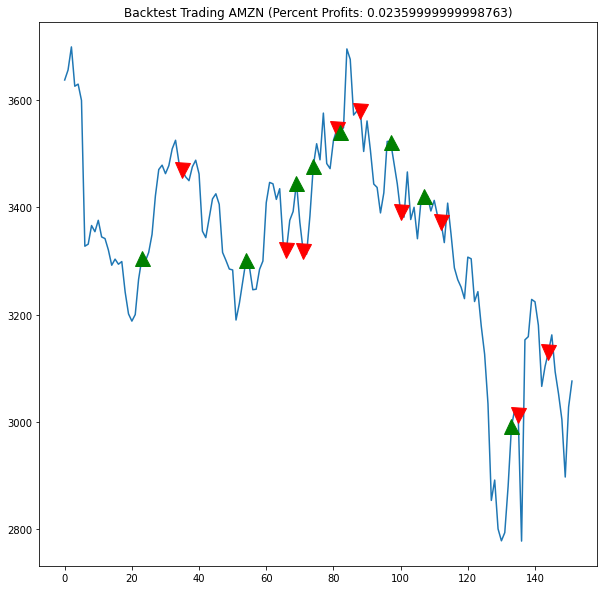

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:272: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.


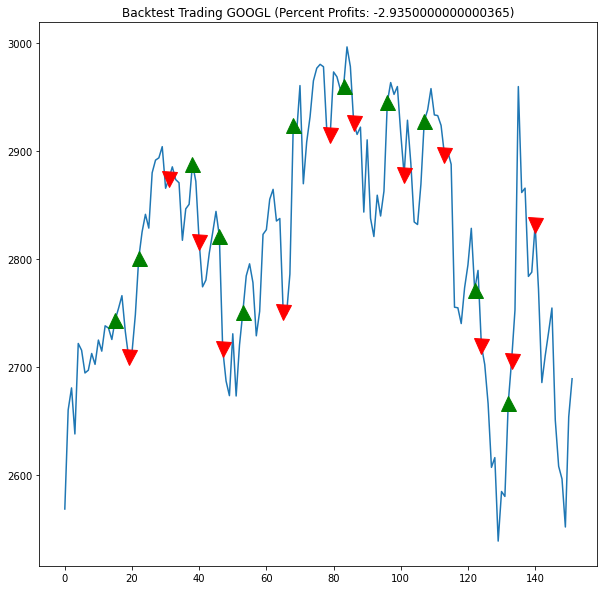

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:272: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.


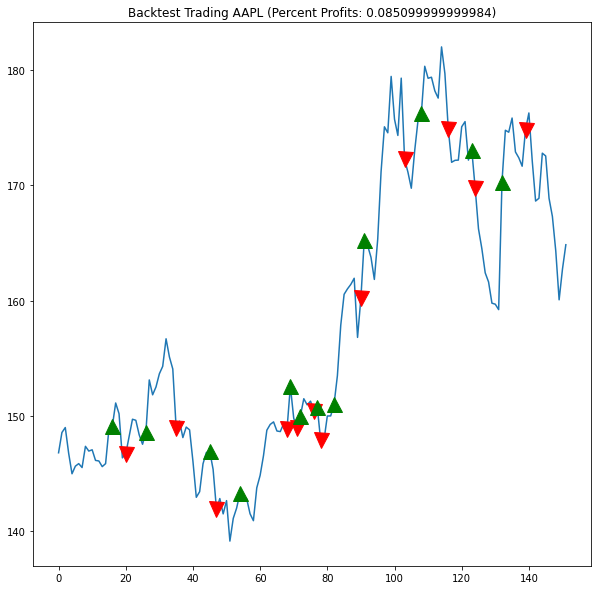

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:272: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.


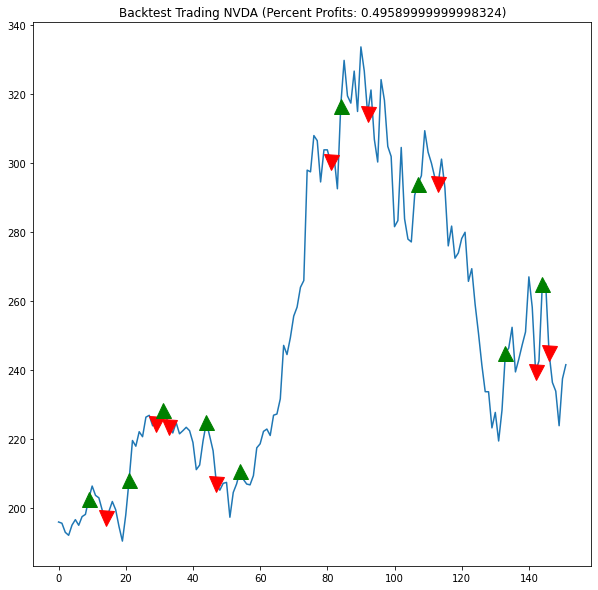

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:272: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.


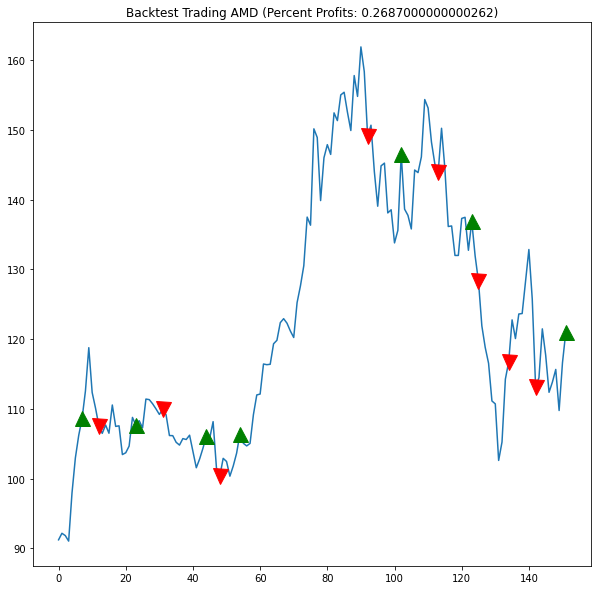

In [ ]:
ema_sma_cross_strategies = {}
total_start = 0
total_end = 0

for stock in STOCKS:
  ema_sma_cross_strategies[stock] = BaselineCrossoverStrategy(stock, DAYS,
                                                fast_method="EMA", 
                                                slow_method="SMA", 
                                                ema_fast_beta=0.3, 
                                                sma_slow_period=8)

  actions, ending_money = ema_sma_cross_strategies[stock].run_backtest()

  ema_sma_cross_strategies[stock].plot_backtest_trades()

  total_start += ema_sma_cross_strategies[stock].BACKTEST_START_MONEY
  total_end += ema_sma_cross_strategies[stock].backtest_money

  profit_percentages.loc['EmaSmaCross',stock] = "{:.2f}%".format(100*(ema_sma_cross_strategies[stock].backtest_money - ema_sma_cross_strategies[stock].BACKTEST_START_MONEY) / ema_sma_cross_strategies[stock].BACKTEST_START_MONEY)
  profit_totals.loc['EmaSmaCross',stock] = "${:.2f}".format(ema_sma_cross_strategies[stock].backtest_money - ema_sma_cross_strategies[stock].BACKTEST_START_MONEY)
  
profit_percentages.loc['EmaSmaCross','Total'] = "{:.2f}%".format(100*(total_end - total_start) / total_start)
profit_totals.loc['EmaSmaCross','Total'] = "${:.2f}".format(total_end - total_start)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:272: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.


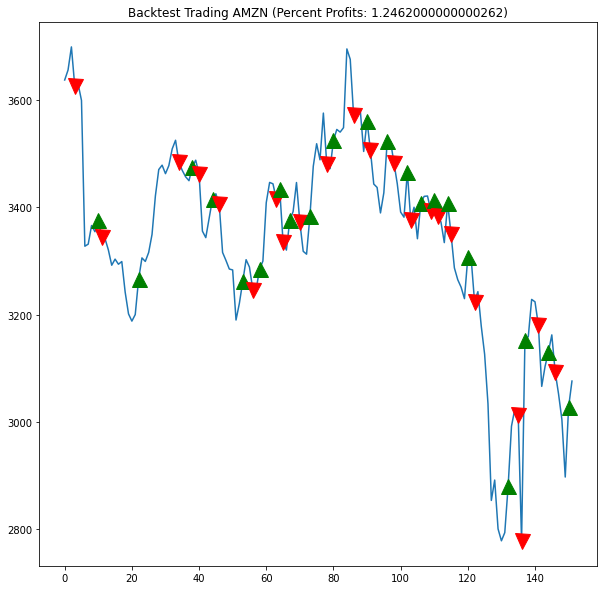

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:272: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.


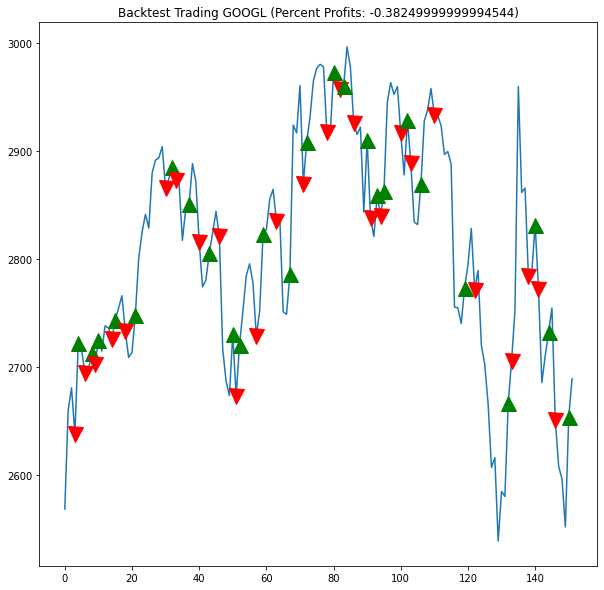

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:272: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.


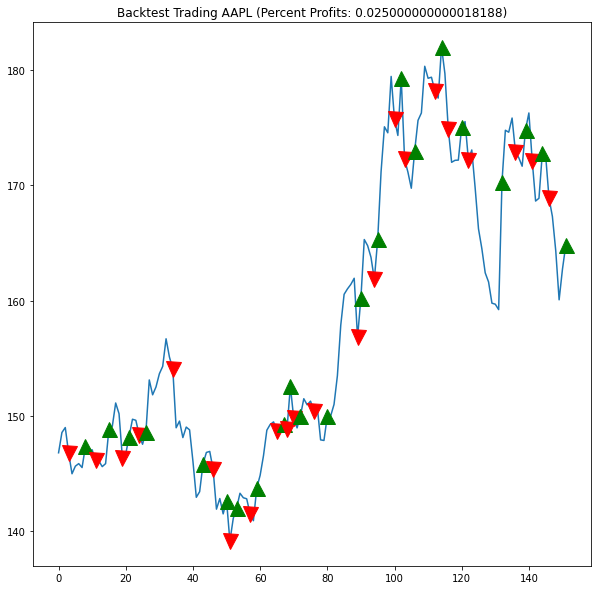

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:272: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.


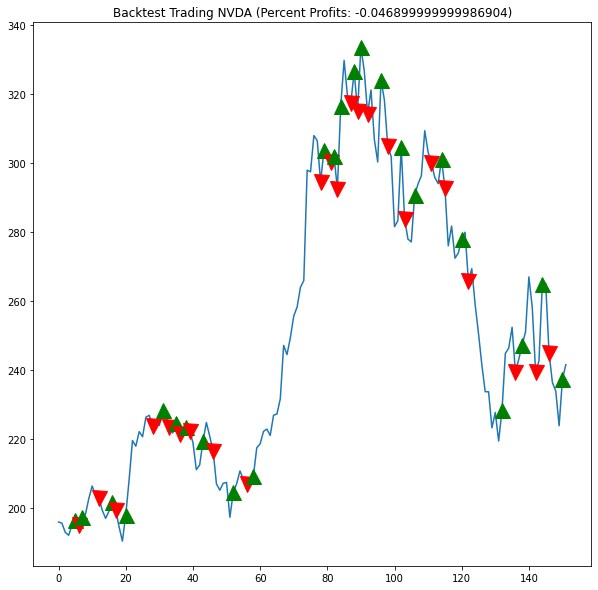

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:272: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.


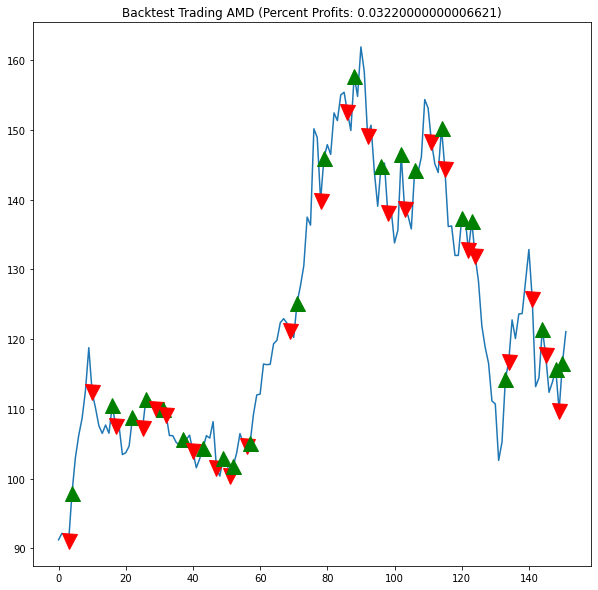

In [ ]:
ema_cross_strategies = {}
total_start = 0
total_end = 0

for stock in STOCKS:
  ema_cross_strategies[stock] = BaselineCrossoverStrategy(stock, DAYS,
                                                fast_method="EMA", 
                                                slow_method="EMA", 
                                                ema_fast_beta=0.8, 
                                                ema_slow_beta=0.6)

  actions, ending_money = ema_cross_strategies[stock].run_backtest()

  ema_cross_strategies[stock].plot_backtest_trades()

  total_start += ema_cross_strategies[stock].BACKTEST_START_MONEY
  total_end += ema_cross_strategies[stock].backtest_money

  profit_percentages.loc['EmaCross',stock] = "{:.2f}%".format(100*(ema_cross_strategies[stock].backtest_money - ema_cross_strategies[stock].BACKTEST_START_MONEY) / ema_cross_strategies[stock].BACKTEST_START_MONEY)
  profit_totals.loc['EmaCross',stock] = "${:.2f}".format(ema_cross_strategies[stock].backtest_money - ema_cross_strategies[stock].BACKTEST_START_MONEY)
  
profit_percentages.loc['EmaCross','Total'] = "{:.2f}%".format(100*(total_end - total_start) / total_start)
profit_totals.loc['EmaCross','Total'] = "${:.2f}".format(total_end - total_start)

In [ ]:
'''
Simple class to generate and manage STL model using Prophet
'''
class STL:
  def __init__(self, bars, FUTURE_DAYS=10, changepoint_prior_scale=0.001):
    self.FUTURE_DAYS = FUTURE_DAYS
    self.model = None
    self.forecast = None
    self.changepoint_prior_scale = changepoint_prior_scale
    self.fit_and_forecast(bars)

  def get_future_day(self, future_day=None):
    if isinstance(future_day, type(datetime.date)) and future_day in self.forecast['ds']:
      # Get data for a specific date
      return self.forecast.loc[self.forecast['ds'] == future_day]
    elif isinstance(future_day, int) and future_day < self.FUTURE_DAYS and future_day > 0:
      # Get data for day that is an integer number of days into the future
      return self.forecast.iloc[future_day - self.FUTURE_DAYS]
    else:
      # Get first predicted day
      return self.forecast.iloc[-self.FUTURE_DAYS]

  def fit_and_forecast(self, bars):
    self.model = Prophet(changepoint_prior_scale=self.changepoint_prior_scale)

    data = bars.copy()
    data.index = [d.date() for d in data.index]
    data = pd.DataFrame([data.index, data['close'].values]).transpose()
    data.columns = ['ds', 'y']

    self.model.fit(data)
    future = self.model.make_future_dataframe(periods=self.FUTURE_DAYS)

    self.forecast = self.model.predict(future)

'''
STL Strategy using y_hat predictions and bounds to determine when to buy and sell
'''
class STLStrategy(TradingStrategy):
  '''
  '''
  def __init__(self, STOCK, DAYS, FUTURE_DAYS=10, changepoint_prior_scale=0.001, bound_factor=2.5):
    super().__init__(STOCK, DAYS)
    self.stl_model = STL(self.bars, FUTURE_DAYS, changepoint_prior_scale)
    self.bound_factor = bound_factor
    self.hold_count = 0
    self.last_action = None
    self.HOLD_DAYS = 2
  
  '''
  ''' 
  def preprocess_strategy(self, bars):
    self.stl_model.fit_and_forecast(bars)

  '''
  '''
  def execute_strategy(self, bars, current_price, is_backtest=False):
    action = None
    future_day = None

    self.stl_model.fit_and_forecast(bars)

    if is_backtest:
      # get most recent prediction
      future_day = self.stl_model.get_future_day()
    else:
      # get prediction for today's date
      future_day = self.stl_model.get_future_day(date.today())

    predicted_price = future_day['yhat']
    upper_bound = future_day['yhat_upper']
    lower_bound = future_day['yhat_lower']

    if current_price < predicted_price - (predicted_price - lower_bound)*self.bound_factor:
      # Buy if the current price is below the lower bound of the predicted price.
      # This indicates an anomaly of a drop in price
      action = "BUY"
    elif current_price > predicted_price + (upper_bound - predicted_price)*self.bound_factor:
      # Buy if the current price is below the lower bound of the predicted price.
      # This indicates an anomaly of a rise in price
      action = "SELL"

    return action

In [ ]:

train_percent = 5.0/12.0

stl_strategies = {}

for stock in STOCKS:
  stl_strategies[stock] = STLStrategy(stock, DAYS, 10, 0.05, 1.5)

  actions, ending_money = stl_strategies[stock].run_backtest_bars(train_percent)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to overr

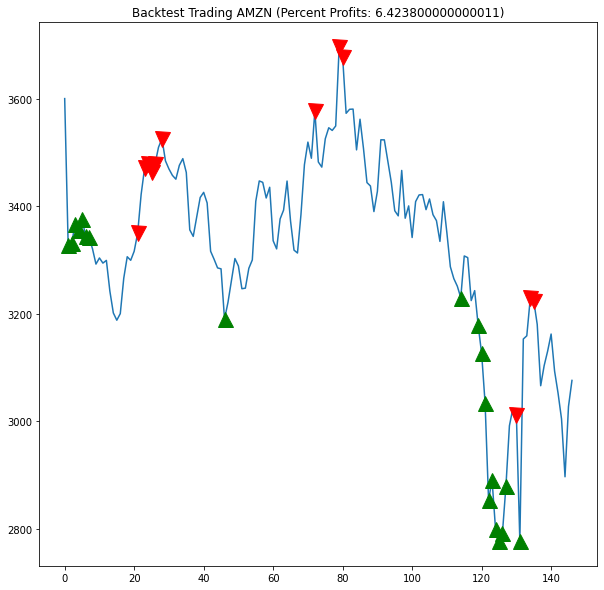

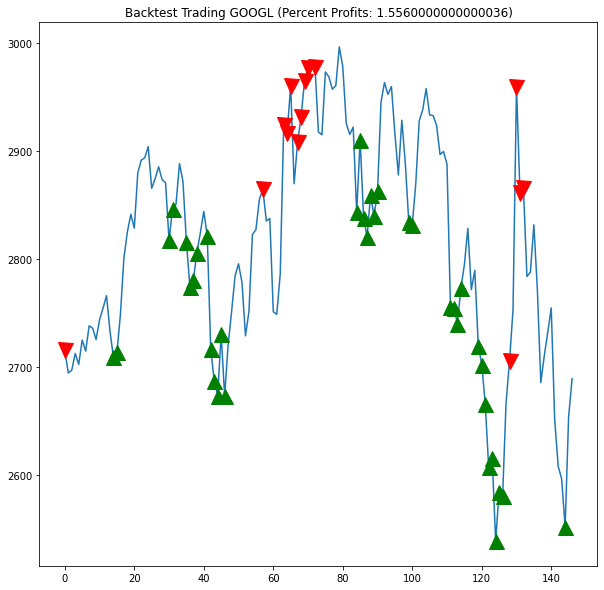

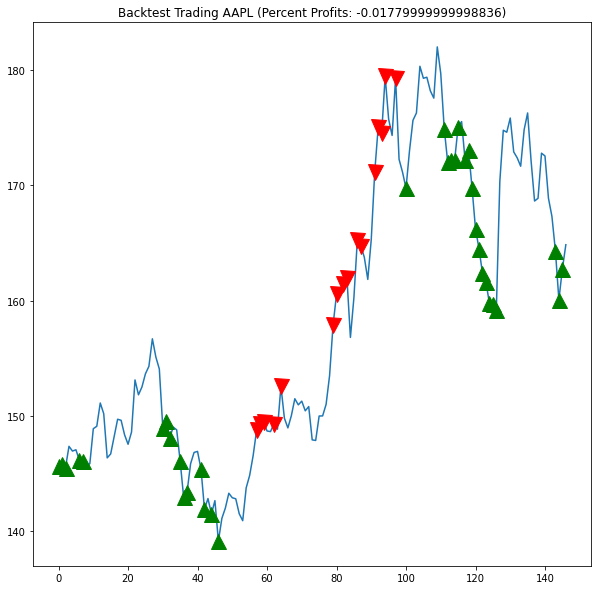

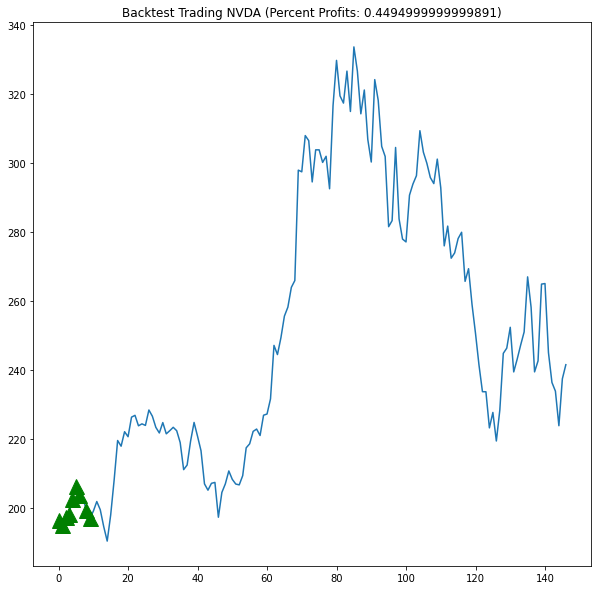

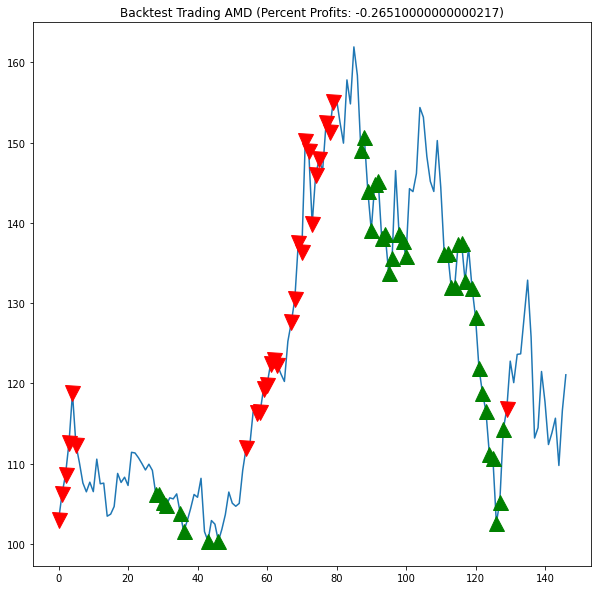

In [ ]:
total_start = 0
total_end = 0

for strategy in stl_strategies:
  stl_strategies[strategy].plot_backtest_trades()

  total_start += stl_strategies[strategy].BACKTEST_START_MONEY
  total_end += stl_strategies[strategy].backtest_money

  profit_percentages.loc['STL',strategy] = "{:.2f}%".format(100*(stl_strategies[strategy].backtest_money - stl_strategies[strategy].BACKTEST_START_MONEY) / stl_strategies[strategy].BACKTEST_START_MONEY)
  profit_totals.loc['STL',strategy] = "${:.2f}".format(stl_strategies[strategy].backtest_money - stl_strategies[strategy].BACKTEST_START_MONEY)
  
profit_percentages.loc['STL','Total'] = "{:.2f}%".format(100*(total_end - total_start) / total_start)
profit_totals.loc['STL','Total'] = "${:.2f}".format(total_end - total_start)

In [6]:
# ---------------------------------------------------------------------------------#

#                         Definitions for Generating Data Frames                           #

# ---------------------------------------------------------------------------------#

'''
Single Data Points information per data point, ie 7 features plus label
'''
def create_data(yrs=1, STOCK='GOOG', fast_method='EMA', slow_method='SMA',
                            fast_sma=5, slow_sma=15, fast_ema=0.5, slow_ema=0.2, gainz_threshold = 1.01, debug=False) :
    if debug:                         
      print('----------------------------')
      print(f'Gathering Data for {STOCK}')
      print('----------------------------')
      
    # Create instance of BCS
   
    ML_strat = BaselineCrossoverStrategy(
        STOCK, 232*yrs, 
        fast_method=fast_method,
        slow_method=slow_method, 
        sma_fast_period=fast_sma, sma_slow_period=slow_sma, 
        ema_fast_beta=fast_ema, ema_slow_beta=slow_ema
        )
      
    # set the sell limit factor for determining when to sell
    ML_strat.SELL_LIMIT_FACTOR = gainz_threshold

    # Closing Prices Data
    closing_prices = ML_strat.bars['close'].values

    # Get Fast and Slow SMA or EMA curves
    fast, slow = ML_strat.generate_fast_slow()

    # Set sma_var to correct variable
    sma_var = []
    if fast_method == 'SMA': sma_var[:] = slow[:]
    elif slow_method == 'SMA': sma_var[:] = fast[:]
    else: sma_var[:] = slow[:]

    # Get STD, upper std and lower std
    upper_dev, lower_dev, devs = [], [], []
    for i in range(len(closing_prices)):
        devs.append(abs(closing_prices[i] - sma_var[i])) # use whichever is the SMA: slow here
        upper_dev.append(slow[i] + 2*devs[i]) 
        lower_dev.append(slow[i] - 2*devs[i]) 

    # Graph Data
    if debug:
      x = np.arange(1, len(closing_prices)+1 )
      y = closing_prices
      plt.plot(x,y) # plot the actual prices
      plt.plot(slow) # plot the slow method
      plt.plot(upper_dev) # plot upper standard devs
      plt.plot(lower_dev) # plot lower standard devs
      plt.plot(fast) # plot the fast method
    
    
    # Generate Slope Points from slow SMA curve
    slopes = [0]
    last_slow_point = slow[0]
    for i in range(1,len(slow)):
        curr_point = slow[i]
        slopes.append(curr_point - last_slow_point)
        last_slow_point = curr_point

    #print(len(data))
    #print(slopes)

     # Create Pandas DataFrame
    df = pd.DataFrame(index=[np.arange(len(closing_prices))])
    df['Closing Prices'] = closing_prices
    df['SMA'] = slow
    df['EMA'] = fast
    df['devs'] = devs
    df['upper_dev'] = upper_dev
    df['lower_dev'] = lower_dev
    df['slopes'] = slopes

    #print(df.head(-1))
    for i in range(15):
        df = df.drop(index=i)
    #print(df.shape)

    #Generate Labels
    labels = [] # 0 means hold, 1 means buy, 2 means sell!
    bought = False
    cropped_data = df['Closing Prices'].values
    cropped_slopes = df['slopes'].values
    buy_price = 0

    for i in range(len(cropped_data)-2):
        if cropped_data[i+2] > cropped_data[i] and cropped_data[i+1] > cropped_data[i] and cropped_data[i-2] > cropped_data[i] and cropped_data[i-1] > cropped_data[i]:
            labels.append(1)
            bought = True
            buy_price = cropped_data[i]
        elif cropped_data[i+2] < cropped_data[i] and cropped_data[i+1] < cropped_data[i] and cropped_data[i-2] < cropped_data[i] and cropped_data[i-1] < cropped_data[i]:
            labels.append(2)
            bought = False
        else: 
            labels.append(0)
    #drop the last index since it doesnt have a label
    df = df.drop(index=len(closing_prices)-2)
    df = df.drop(index=len(closing_prices)-3)
    #df = df.drop(index=len(closing_prices)-4)
    #add labels to df
    df['labels'] = labels
    
    return df

'''
Create a mega dataframe of appended single stock dataframes
'''
def concat_dfs(STOCKS, yrs, fast_method='EMA', slow_method='SMA', fast_sma=5, slow_sma=15, 
               fast_ema=0.5, slow_ema=0.2,gainz_threshold=1.01, stack=False, debug=False):
    # create mega_frame from first stock df
    mega_frame = create_data(yrs=yrs, STOCK=STOCKS[0], fast_method=fast_method, slow_method=slow_method,
                             fast_sma=fast_sma, slow_sma=slow_sma, fast_ema=fast_ema, slow_ema=slow_ema)
    if stack: mega_frame = feature_stack(mega_frame)
    if debug: print(f'Shape of DataFrame: {mega_frame.shape}')
    for i in range(1,len(STOCKS)):
        temp_df = create_data(yrs=yrs, STOCK=STOCKS[i], fast_method=fast_method, slow_method=slow_method,
                              fast_sma=fast_sma, slow_sma=slow_sma, fast_ema=fast_ema, slow_ema=slow_ema)
        if stack: temp_def = feature_stack(temp_df)
        mega_frame = pd.concat([mega_frame, temp_df])
        if debug: print(f'Shape of DataFrame: {mega_frame.shape}')
    return mega_frame


'''
Create DataFrame from existing dataframe where each datapoint has closing price,
SMA, and EMA from previous 4 datapoints. 
Input Dimensions (n,8) -- 7 + label
Output Dimensions (n-4,24) 23 + label
'''
def feature_stack(df1):
    #define the extra columns
    extra_cols = ['CP', 'SMA', 'EMA', 'slope','CP', 'SMA', 'EMA', 'slope','CP', 'SMA',
    'EMA', 'slope','CP', 'SMA', 'EMA', 'slope']

    # grab the prices for continued modification 
    cps = df1['Closing Prices'].values 
    sma = df1['SMA'].values
    ema = df1['EMA'].values
    slope = df1['slopes'].values

    count = 0

    for i in range(len(extra_cols)):
        if i%4 == 0: count += 1  # iterator for column labels
        if extra_cols[i] == 'CP': # if the value is Closing Price
            cps = np.delete(cps,-1) # remove the last element 
            cps = np.insert(cps,0,0) # make the first element 0 
            df1[extra_cols[i]+str(count)] = cps # append that column to the correct column in the df
        elif extra_cols[i] == 'SMA':
            sma = np.delete(sma,-1)
            sma = np.insert(sma,0,0)
            df1[extra_cols[i]+str(count)] = sma
        elif extra_cols[i] == 'EMA':
            ema = np.delete(ema,-1)
            ema = np.insert(ema,0,0)
            df1[extra_cols[i]+str(count)] = ema
        elif extra_cols[i] == 'slope':
            slope = np.delete(slope,-1)
            slope = np.insert(slope,0,0)
            df1[extra_cols[i]+str(count)] = slope

    for i in range(15,19):
        df1 = df1.drop(index=i)

    return df1



In [7]:
# ---------------------------------------------------------------------------------#

#                               Labeled Data Example Graph                                      #

# ---------------------------------------------------------------------------------#
def labeled_data_ex(stock='GOOG', yrs=(5/12)):

    df1 = create_data(yrs=yrs, STOCK=stock)
    df1_target = df1.pop('labels')

    actual_data = df1['Closing Prices']
    indices = actual_data.index
    print(f'Actual Labeled Data Example Graphed for {stock} for {yrs} years')
    plt.figure(figsize=(20,10))
    plt.plot(df1['Closing Prices'].values)

    for i,label in enumerate(df1_target):
        x = indices[i][0] - 15
        if label == 1:
            plt.plot(x, actual_data.values[i], marker='^', markersize=10, markeredgecolor="green", markerfacecolor="green")
        elif label == 2:
            plt.plot(x, actual_data.values[i], marker='v', markersize=10, markeredgecolor="red", markerfacecolor="red")
    plt.title(f'Algorithmic Labels for {stock} stock', color='white', size=25)    
    plt.show()

In [8]:
# ---------------------------------------------------------------------------------#

#                          Definition for ML Ridge Classifier                                   #

# ---------------------------------------------------------------------------------#
def ML(X_train, y_train, X_test=None, y_test=None, max_iter=800, alpha=0.01, normalize=True, debug=False):
    if normalize:
        mu, std = X_train.mean(), X_train.std()
        X_train = (X_train-mu) / std

        if debug:
          mu, std = X_test.mean(), X_test.std()
          X_test = (X_test-mu) / std

    model_ridge = LR_ridge(max_iter=max_iter, alpha=alpha).fit(X_train, y_train)

    if debug:
      '''
      debug mode: printing results for predictions and plotting results. 
      '''
      pred_train = model_ridge.predict(X_train)
      pred_test = model_ridge.predict(X_test)

      print(f'\nf1 score train: {f1(y_train, pred_train, average="weighted")}')
      print(f'f1 score test: {f1(y_test, pred_test, average="weighted")}')

      print(f'\nDimensions of Train Set: {X_train.shape}')
      print(f'Dimensions of Test Set: {X_test.shape}')

      '''
      The ML algorithm predictions with current parameters and labeled train data
      '''
      actual_data = X_test['Closing Prices']
      indices = actual_data.index

      print(f'Logistic Regression Predictions Graphed')
      plt.figure(figsize=(20,10))
      plt.plot(X_test['Closing Prices'].values)

      for i,pred in enumerate(pred_test):
          x = indices[i][0] - indices[0][0]
          if pred == 1:
              plt.plot(x, actual_data.values[i], marker='^', markersize=10, markeredgecolor="green", markerfacecolor="green")
          elif pred == 2:
              plt.plot(x, actual_data.values[i], marker='v', markersize=10, markeredgecolor="red", markerfacecolor="red")
      plt.title('Logistic Regression Predicted Values', color='white', size=25)

      plt.show()

    return model_ridge


# ---------------------------------------------------------------------------------#

#                        Definition for Generating ML Model                                  #

# ---------------------------------------------------------------------------------#
def generate_ML_model(stock, debug=False, alpha=0.001):
    # Hyper Params
    STOCKS = ['GOOG', 'MSFT','FB'] 
    test_stock = stock
    yrs = 1
    fast_sma = 5
    slow_sma = 15 # active
    fast_ema = 0.6 # active
    slow_ema = 0.2
    fast_method = 'EMA'
    slow_method = 'SMA'
    stack = True

    if debug: 
      # What the Labeled Data looks like for given stock:
      labeled_data_ex(test_stock)

    # Generate Multi Stock Train Dataset w/out feature stacking for ML - Ridge Regression
      print('Generating Train DataFrame:')
    X_train = concat_dfs(STOCKS, yrs, fast_method=fast_method, slow_method=slow_method, 
                    fast_sma=fast_sma, slow_sma=slow_sma, fast_ema=fast_ema, slow_ema=slow_ema,
                    stack=stack, debug=debug)

    # Save df to csv
    if debug:
      X_train.to_csv('./data.csv')
    
    # use labels column as target (y_train)
    y_train = X_train.pop('labels')

    # Generate Test Data
    if debug:
      print('\nGenerating Test DataFrame:')
      X_test = create_data(yrs=(5/12), STOCK=test_stock, fast_method=fast_method, slow_method=slow_method)
      if stack: X_test = feature_stack(X_test)
      y_test = X_test.pop('labels')
      
      # Run the ML Ridge Regression on the Data
      print(f'\nHyper-Parameter Settings:')
      print(f' years of data for train/val: {yrs}\n \
      Stocks for Train: {STOCKS}\n \
      Stock for Test: \'{test_stock}\'\n \
      Fast Method = {fast_method}\n \
      Slow Method = {slow_method}\n \
      Fast EMA Beta: {fast_ema}\n \
      Slow EMA Beta: {slow_ema}\n \
      Fast SMA Value: {fast_sma}\n \
      Slow SMA Value: {slow_sma}\n \
      Feature Stacking: {stack}\n')
      print('\nML Ridge Classifier')
        
    if debug: model = ML(X_train, y_train, X_test, y_test, alpha=alpha, debug=debug)
    else: model = ML(X_train, y_train, alpha=alpha)

    return model


# ---------------------------------------------------------------------------------#

#                   Definition for ML Based Buy/Sell Strategy                            #

# ---------------------------------------------------------------------------------#
class ML_Strategy(TradingStrategy):
 
  def __init__(self, STOCK, DAYS, MODEL, debug=False):
    super().__init__(STOCK, DAYS)
    self.model = MODEL
    self.available_cash = self.BACKTEST_START_MONEY
    self.sum_price = 0
    self.count_buys = 0
    self.debug = debug
    self.actions = []

    # needed parameters for creating backtesting data and live trade previous data
    # MUST BE THE SAME PARAMETERS USED IN TRAINING OF ML MODEL - static
    self.yrs = (5/12)
    self.fast_sma = 5
    self.slow_sma = 15 # active
    self.fast_ema = 0.6 # active
    self.slow_ema = 0.2
    self.fast_method = 'EMA'
    self.slow_method = 'SMA'

  '''
  Implement Live Trading
  '''
  def run_live():
    pass

  '''
  Generate data using previous stock data
  '''
  def generate_backtest_data(self):
    data = create_data(yrs=self.yrs, STOCK=self.STOCK, fast_method=self.fast_method, slow_method=self.slow_method)
    data = feature_stack(data)
    _ = data.pop('labels') # remove the labels from the data

    self.data = data
  
  '''
  Helper functions for backtesting
  '''
  def get_buy_quantity_backtest(self):
    if self.count_buys < 4:
      return int((self.available_cash / ((1/(self.count_buys+1)) * 7))) / self.current_stock_amount
    else: 
      return 0

  def reset_vars(self):
    #reset the counts upon selling -- ie sells all stock
    self.sum_price = 0
    self.current_num_stocks = 0
    self.count_buys = 0

  def sell_backtest(self, force=False):
    if force: 
      self.available_cash += self.current_stock_amount * self.current_num_stocks
      self.actions.append(2)
      if self.debug:
        print(f'Sell: {self.current_num_stocks} @ {self.current_stock_amount}')
        print(f'Available Cash: {self.available_cash}\n')
      self.reset_vars()
      return

    # only sell if greater than threshold sell limit factor * average price of the stocks bought    
    if (self.current_num_stocks * self.current_stock_amount) >= self.SELL_LIMIT_FACTOR * self.sum_price and self.current_num_stocks > 0:
      self.available_cash += self.current_stock_amount * self.current_num_stocks
      self.actions.append(2)
      if self.debug:
        print(f'Sell: {self.current_num_stocks} @ {self.current_stock_amount}')
        print(f'Available Cash: {self.available_cash}\n')
      self.reset_vars()
      return 
    
    self.actions.append(0) # if stock doesnt sell - append a 0 for hold

  def buy_backtest(self):
    # simulate buy by tracking quantity bought and available cash
    q = self.get_buy_quantity_backtest()
    if q > 0: 
      self.count_buys += 1
      self.actions.append(1)
    else: self.actions.append(0)
    self.available_cash -= q * self.current_stock_amount
    self.current_num_stocks += q
    if self.debug:
      print(f'Buy: {q} @ {self.current_stock_amount} = {q*self.current_stock_amount}')
      print(f'Available Cash: {self.available_cash}')

    # increment total sum 
    self.sum_price += self.current_stock_amount * q
    if self.debug:
      print(f'sum price: {self.sum_price}\n')

    if self.current_num_stocks == 0: self.reset_vars()


  def plot(self):
    actual_data = self.data['Closing Prices']
    indices = actual_data.index
    print(f'Logistic Regression Buy/Sell Actions Taken')
    plt.figure(figsize=(20,10))
    plt.plot(self.data['Closing Prices'].values)

    if self.debug:
      print(f'num actions: {len(self.actions)}')
      print(f'num indices: {len(indices)}')

    for i,action in enumerate(self.actions):
        if i >= len(indices): break
        x = indices[i][0] - indices[0][0]
        if action == 1:
            plt.plot(x, actual_data.values[i], marker='^', markersize=10, markeredgecolor="green", markerfacecolor="green")
        elif action == 2:
            plt.plot(x, actual_data.values[i], marker='v', markersize=10, markeredgecolor="red", markerfacecolor="red")
        #else:
         #   plt.plot(x, actual_data.values[i], marker='o', markersize=10, markeredgecolor="yellow", markerfacecolor="yellow")
    plt.show()

  
  '''
  Implement Backtesting
  '''
  def run_backtest(self):  
    # generate the data needed for backtesting
    self.generate_backtest_data() # data stored in self.data

    offset = 19
    
    # loop through data to do day by day predictions 
    for i in range(self.data.shape[0]):
      # if day before earnings -- force sell
      if self.dates[i+offset] == self.sell_earning_dates[self.STOCK][0] and self.current_num_stocks > 0:
        if self.debug: print(f'{self.dates[i+offset]} Day Before Earnings... Force Sell')
        self.sell_backtest(force=True)
      # if day of earnings -- hold else execute code below
      elif not self.dates[i+offset] == self.sell_earning_dates[self.STOCK][1]:
        
        # get price at EOD
        self.current_stock_amount = self.data.iloc[i]['Closing Prices']
        
        #predict for that data point
        pred_action = self.model.predict(self.data.iloc[i].values.reshape(1,-1))
        
        if self.debug: print(f'date: {self.dates[i+offset]}')

        #determine course of action
        if pred_action == 1: # buy
          if self.debug:
            print('------buy------')
          self.buy_backtest()
        elif pred_action == 2: # sell
          if self.debug:
            print('------sell------')
          self.sell_backtest()
        else: # hold
          if (self.current_num_stocks * self.current_stock_amount) >= self.SELL_LIMIT_FACTOR * self.sum_price and self.current_num_stocks > 0:
            self.sell_backtest()
          else: self.actions.append(0)
    
    if self.current_num_stocks > 0:
      if self.debug:
        print(f'\nNum stocks to fire sale at end: {self.current_num_stocks}')
      self.sell_backtest(force=True)

    self.net_gainz_percent = ((self.available_cash - self.BACKTEST_START_MONEY) / self.BACKTEST_START_MONEY ) * 100
    net_gainz_money = (self.available_cash - self.BACKTEST_START_MONEY)

    self.plot()

    print(f'Starting Cash: {self.BACKTEST_START_MONEY}\nEnding Cash: {self.available_cash : .2f}\nNet Gains: {self.net_gainz_percent : .2f}%\n')

    return self.net_gainz_percent, net_gainz_money

Stock: AMZN
Actual Labeled Data Example Graphed for AMZN for 0.4166666666666667 years


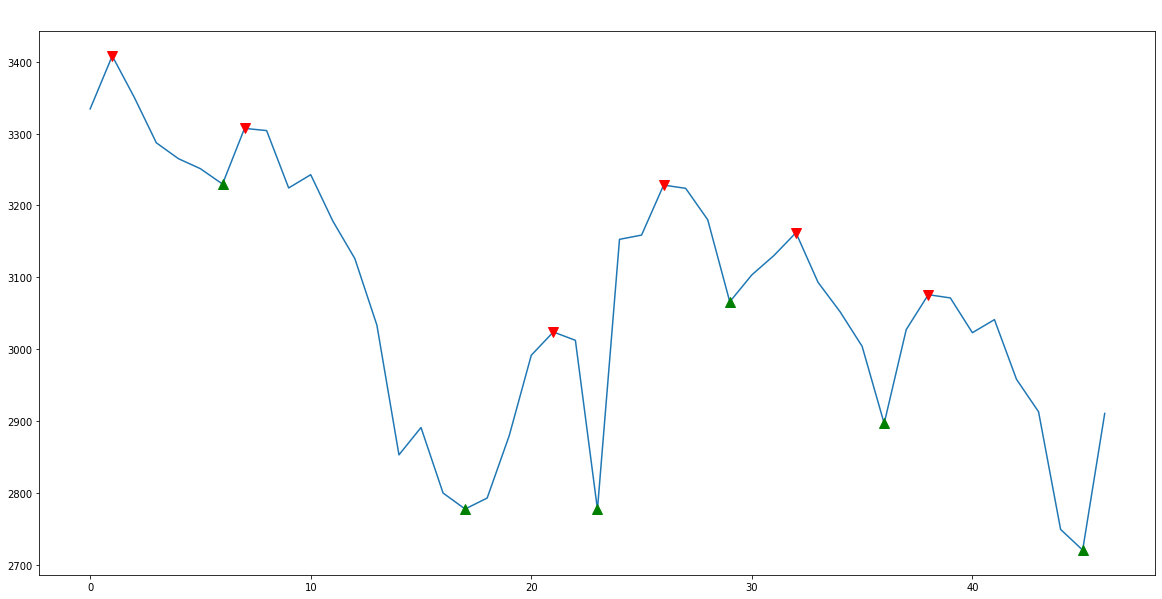

Generating Train DataFrame:
Shape of DataFrame: (139, 24)
Shape of DataFrame: (282, 24)
Shape of DataFrame: (425, 24)

Generating Test DataFrame:

Hyper-Parameter Settings:
 years of data for train/val: 1
       Stocks for Train: ['GOOG', 'MSFT', 'FB']
       Stock for Test: 'AMZN'
       Fast Method = EMA
       Slow Method = SMA
       Fast EMA Beta: 0.6
       Slow EMA Beta: 0.2
       Fast SMA Value: 5
       Slow SMA Value: 15
       Feature Stacking: True


ML Ridge Classifier

f1 score train: 0.6527522487341041
f1 score test: 0.49766492643569055

Dimensions of Train Set: (425, 23)
Dimensions of Test Set: (43, 23)
Logistic Regression Predictions Graphed


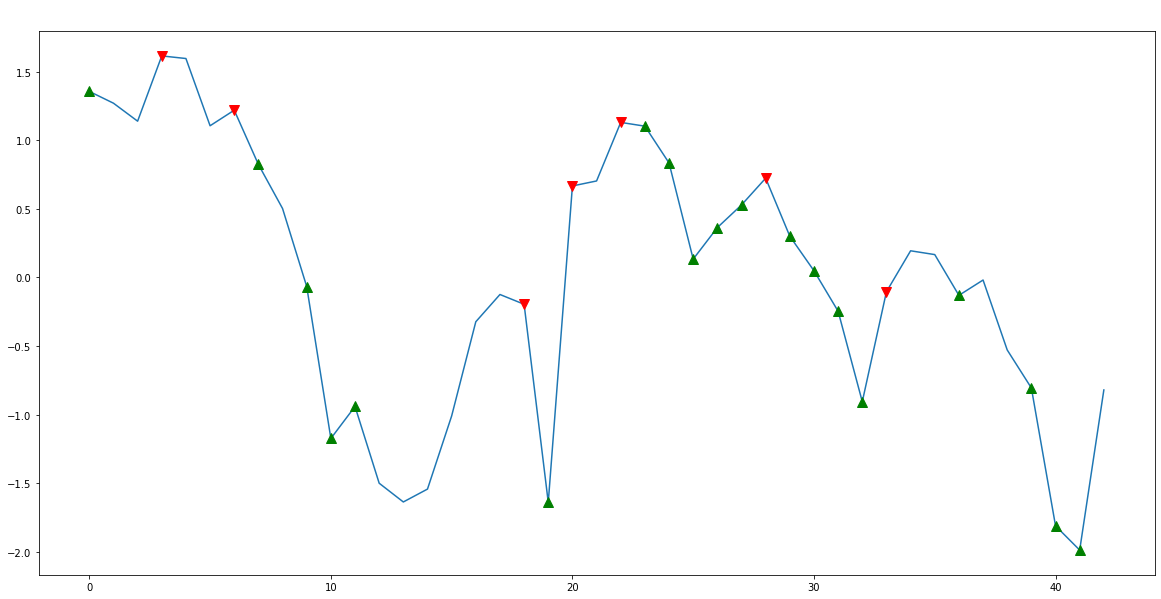

date: 2022-01-06
------buy------
Buy: 0.43735528685361463 @ 3265.08 = 1428.0
Available Cash: 8572.0
sum price: 1428.0

date: 2022-01-07
date: 2022-01-10
date: 2022-01-11
Sell: 0.43735528685361463 @ 3307.24
Available Cash: 10018.438898893748

date: 2022-01-12
date: 2022-01-13
date: 2022-01-14
------sell------
date: 2022-01-18
date: 2022-01-19
date: 2022-01-20
------buy------
Buy: 0.47175564969423245 @ 3033.35 = 1431.0
Available Cash: 8587.438898893748
sum price: 1431.0

date: 2022-01-21
------buy------
Buy: 0.8598388985088647 @ 2852.86 = 2453.0
Available Cash: 6134.438898893748
sum price: 3884.0

date: 2022-01-24
date: 2022-01-25
date: 2022-01-26
date: 2022-01-27
date: 2022-01-28
date: 2022-01-31
Sell: 1.331594548203097 @ 2991.47
Available Cash: 10117.864042006866

date: 2022-02-01
date: 2022-02-02
------sell------
date: 2022-02-04
------sell------
date: 2022-02-07
date: 2022-02-08
------sell------
date: 2022-02-09
------buy------
Buy: 0.4482301886909507 @ 3223.79 = 1445.0
Available Cas

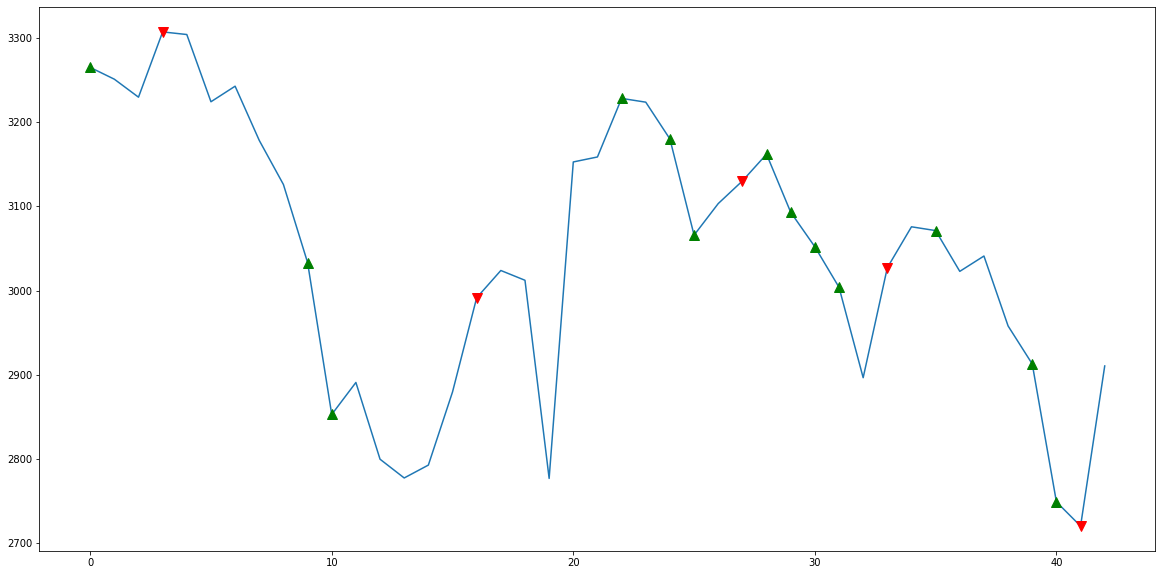

Starting Cash: 10000.0
Ending Cash:  10705.52
Net Gains:  7.06%

Stock: GOOGL
Actual Labeled Data Example Graphed for GOOGL for 0.4166666666666667 years


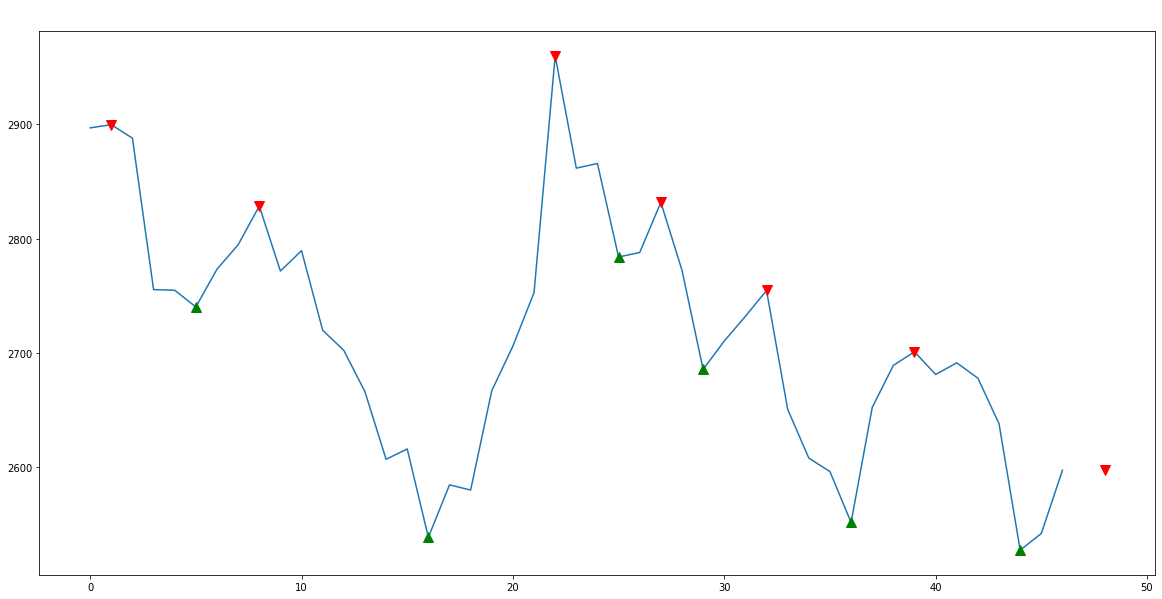

Generating Train DataFrame:
Shape of DataFrame: (139, 24)
Shape of DataFrame: (282, 24)
Shape of DataFrame: (425, 24)

Generating Test DataFrame:

Hyper-Parameter Settings:
 years of data for train/val: 1
       Stocks for Train: ['GOOG', 'MSFT', 'FB']
       Stock for Test: 'GOOGL'
       Fast Method = EMA
       Slow Method = SMA
       Fast EMA Beta: 0.6
       Slow EMA Beta: 0.2
       Fast SMA Value: 5
       Slow SMA Value: 15
       Feature Stacking: True


ML Ridge Classifier

f1 score train: 0.6625824914453315
f1 score test: 0.4823443012455901

Dimensions of Train Set: (425, 23)
Dimensions of Test Set: (43, 23)
Logistic Regression Predictions Graphed


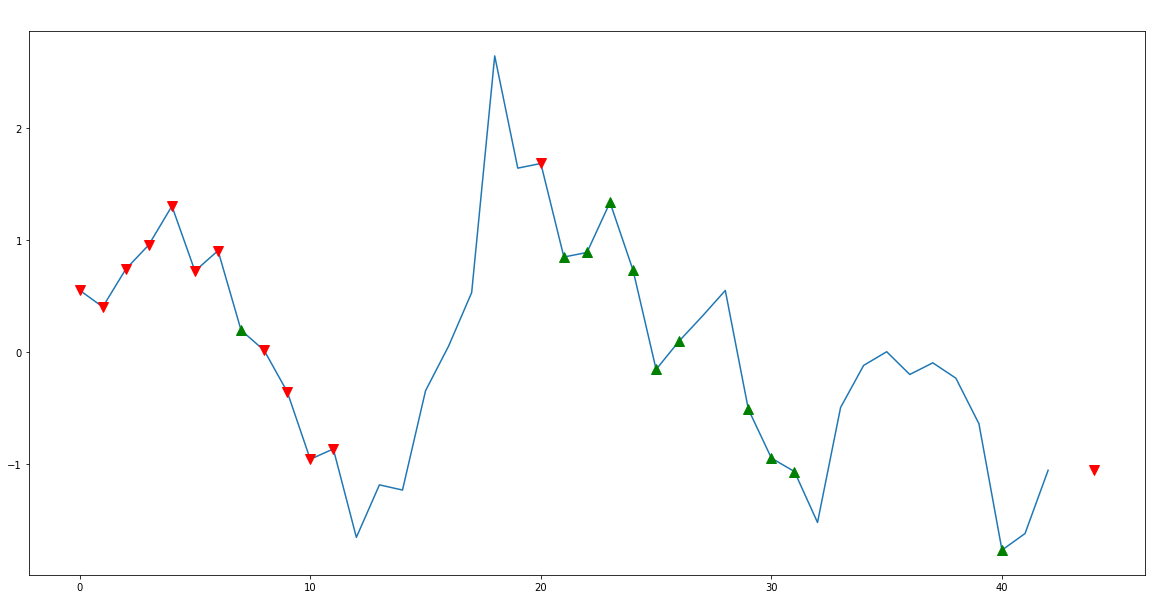

date: 2022-01-06
------sell------
date: 2022-01-07
------buy------
Buy: 0.5211032207682258 @ 2740.34 = 1428.0
Available Cash: 8572.0
sum price: 1428.0

date: 2022-01-10
Sell: 0.5211032207682258 @ 2773.39
Available Cash: 10017.22246144639

date: 2022-01-11
date: 2022-01-12
date: 2022-01-13
------sell------
date: 2022-01-14
------sell------
date: 2022-01-18
------buy------
Buy: 0.5261106780982073 @ 2719.96 = 1431.0
Available Cash: 8586.22246144639
sum price: 1431.0

date: 2022-01-19
------sell------
date: 2022-01-20
------sell------
date: 2022-01-21
------sell------
date: 2022-01-24
------sell------
date: 2022-01-25
------sell------
date: 2022-01-26
------sell------
date: 2022-01-27
------sell------
date: 2022-01-28
2022-01-31 Day Before Earnings... Force Sell
Sell: 0.5261106780982073 @ 2667.02
Available Cash: 9989.370162147872

date: 2022-02-02
date: 2022-02-03
date: 2022-02-04
------sell------
date: 2022-02-07
------buy------
Buy: 0.5125681568379538 @ 2784.02 = 1427.0
Available Cash: 8

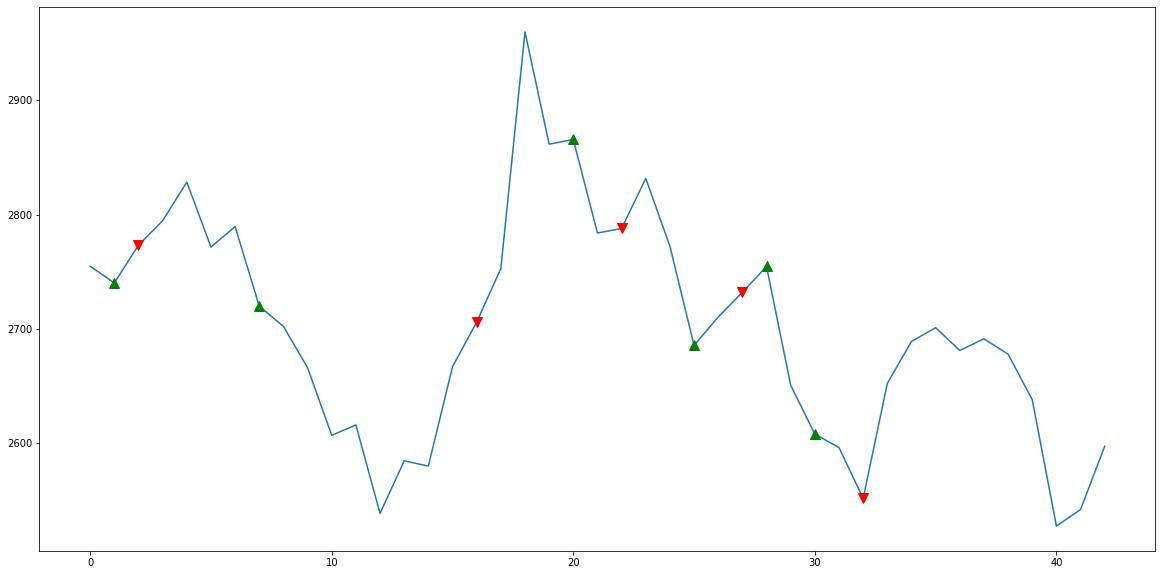

Starting Cash: 10000.0
Ending Cash:  10091.19
Net Gains:  0.91%

Stock: AAPL
Actual Labeled Data Example Graphed for AAPL for 0.4166666666666667 years


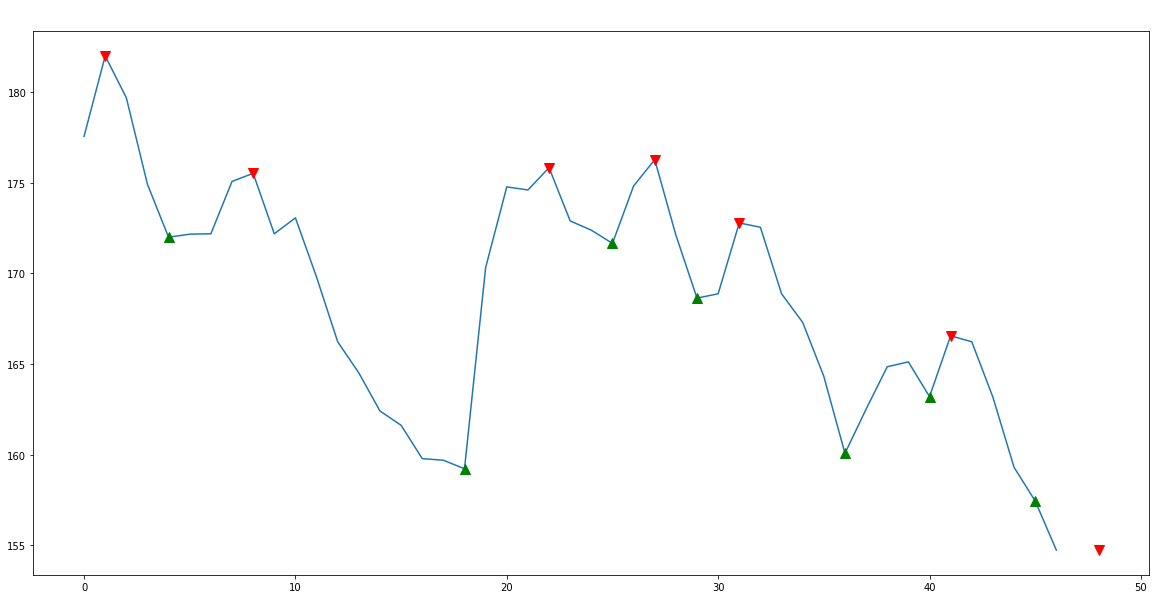

Generating Train DataFrame:
Shape of DataFrame: (139, 24)
Shape of DataFrame: (282, 24)
Shape of DataFrame: (425, 24)

Generating Test DataFrame:

Hyper-Parameter Settings:
 years of data for train/val: 1
       Stocks for Train: ['GOOG', 'MSFT', 'FB']
       Stock for Test: 'AAPL'
       Fast Method = EMA
       Slow Method = SMA
       Fast EMA Beta: 0.6
       Slow EMA Beta: 0.2
       Fast SMA Value: 5
       Slow SMA Value: 15
       Feature Stacking: True


ML Ridge Classifier

f1 score train: 0.6625824914453315
f1 score test: 0.48178294573643415

Dimensions of Train Set: (425, 23)
Dimensions of Test Set: (43, 23)
Logistic Regression Predictions Graphed


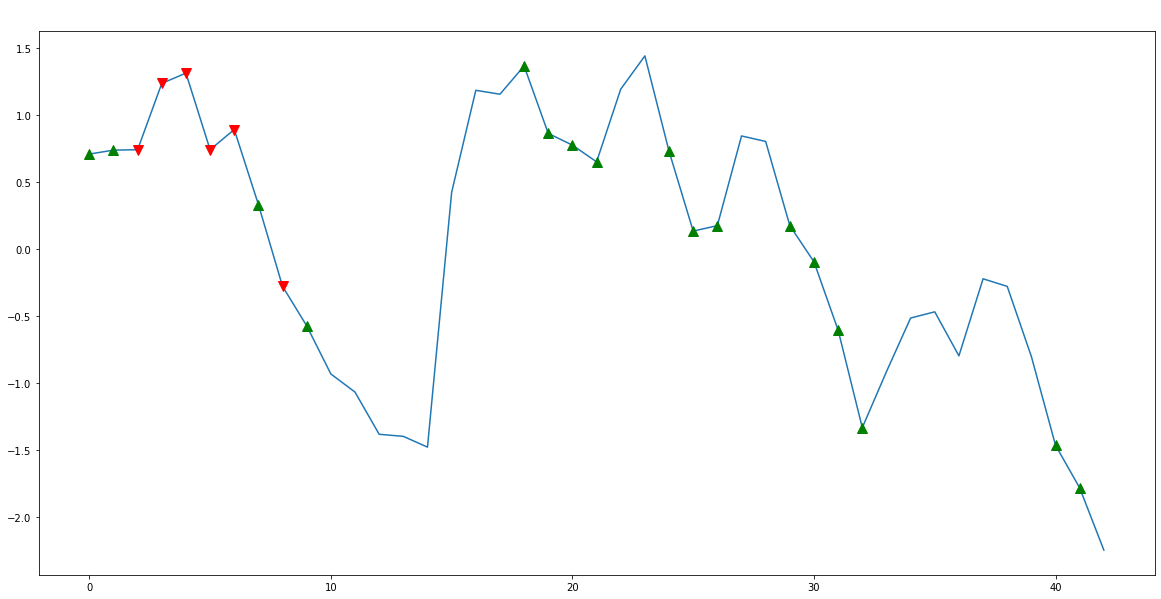

date: 2022-01-06
------buy------
Buy: 8.30232558139535 @ 172.0 = 1428.0
Available Cash: 8572.0
sum price: 1428.0

date: 2022-01-07
date: 2022-01-10
date: 2022-01-11
Sell: 8.30232558139535 @ 175.08
Available Cash: 10025.571162790699

date: 2022-01-12
date: 2022-01-13
date: 2022-01-14
------sell------
date: 2022-01-18
------buy------
Buy: 8.433451118963486 @ 169.8 = 1432.0
Available Cash: 8593.571162790699
sum price: 1432.0

date: 2022-01-19
------sell------
date: 2022-01-20
------buy------
Buy: 14.923104978420765 @ 164.51 = 2455.0
Available Cash: 6138.5711627906985
sum price: 3887.0

date: 2022-01-21
------sell------
date: 2022-01-24
------sell------
date: 2022-01-25
------sell------
date: 2022-01-26
------sell------
date: 2022-01-27
------sell------
date: 2022-01-28
Sell: 23.35655609738425 @ 170.33
Available Cash: 10116.893362858158

date: 2022-01-31
date: 2022-02-01
date: 2022-02-02
------sell------
date: 2022-02-03
date: 2022-02-04
date: 2022-02-07
------buy------
Buy: 8.417802633111

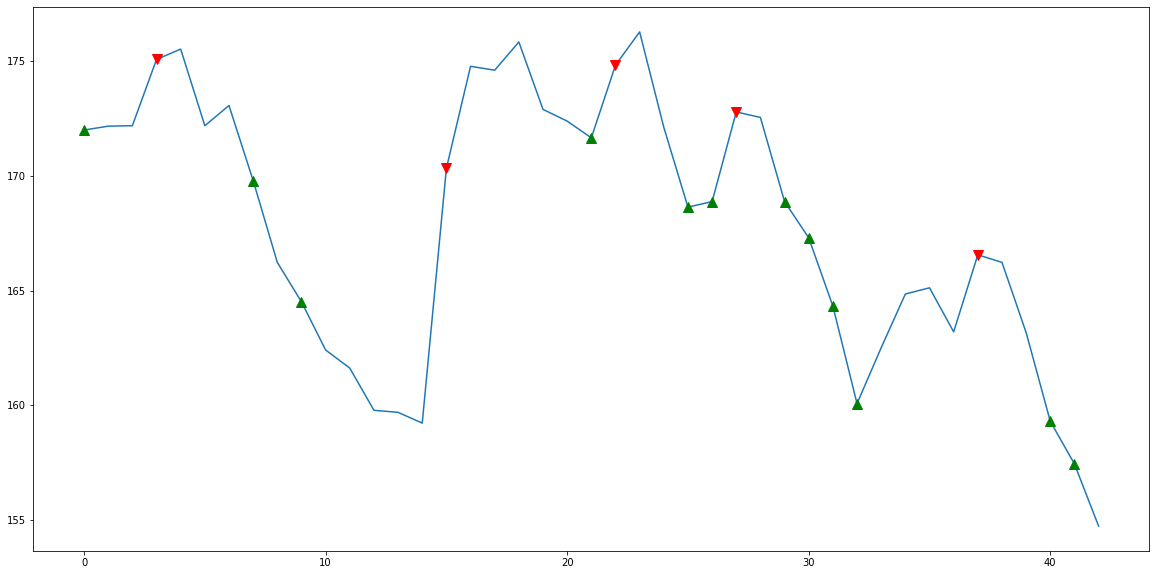

Starting Cash: 10000.0
Ending Cash:  10239.31
Net Gains:  2.39%

Stock: NVDA
Actual Labeled Data Example Graphed for NVDA for 0.4166666666666667 years


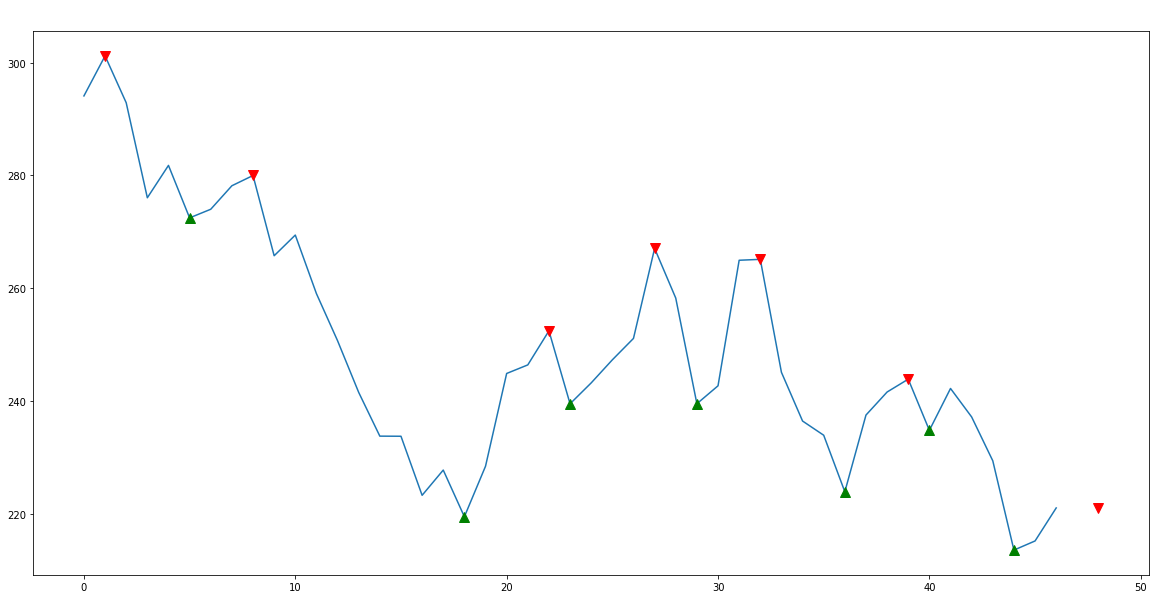

Generating Train DataFrame:
Shape of DataFrame: (139, 24)
Shape of DataFrame: (282, 24)
Shape of DataFrame: (425, 24)

Generating Test DataFrame:

Hyper-Parameter Settings:
 years of data for train/val: 1
       Stocks for Train: ['GOOG', 'MSFT', 'FB']
       Stock for Test: 'NVDA'
       Fast Method = EMA
       Slow Method = SMA
       Fast EMA Beta: 0.6
       Slow EMA Beta: 0.2
       Fast SMA Value: 5
       Slow SMA Value: 15
       Feature Stacking: True


ML Ridge Classifier

f1 score train: 0.6625824914453315
f1 score test: 0.528516057585825

Dimensions of Train Set: (425, 23)
Dimensions of Test Set: (43, 23)
Logistic Regression Predictions Graphed


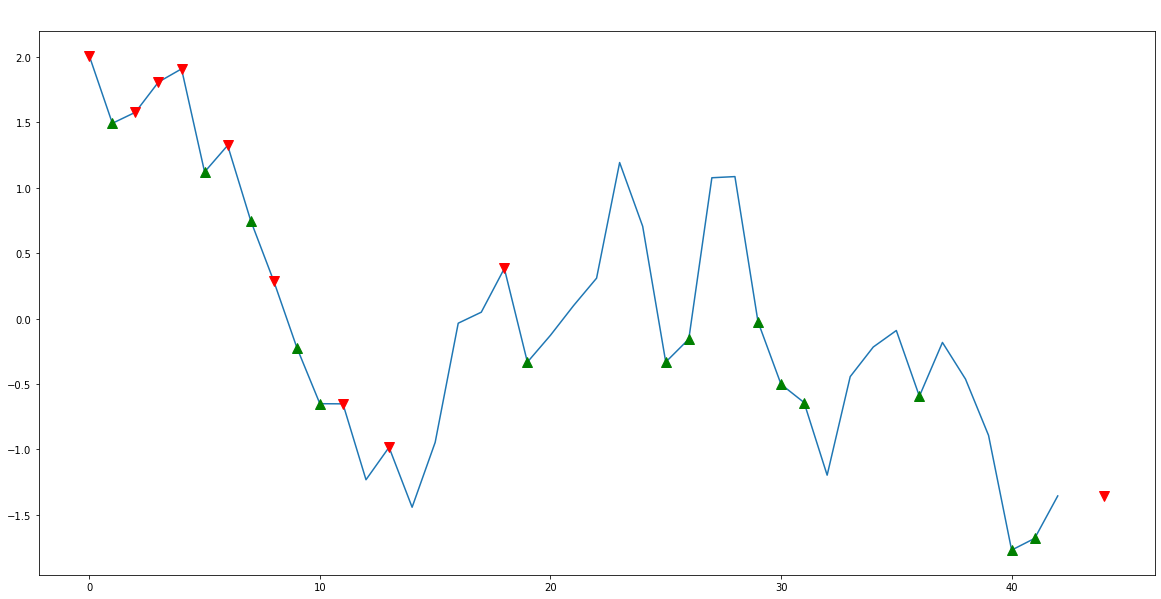

date: 2022-01-06
------buy------
Buy: 5.067783377102705 @ 281.78 = 1428.0
Available Cash: 8572.0
sum price: 1428.0

date: 2022-01-07
date: 2022-01-10
------sell------
date: 2022-01-11
------sell------
date: 2022-01-12
date: 2022-01-13
------buy------
Buy: 9.215428033866417 @ 265.75 = 2449.0
Available Cash: 6123.0
sum price: 3877.0

date: 2022-01-14
------sell------
date: 2022-01-18
------buy------
Buy: 10.13010076052967 @ 259.03 = 2624.0
Available Cash: 3499.0
sum price: 6501.0

date: 2022-01-19
------sell------
date: 2022-01-20
------buy------
Buy: 8.27743271221532 @ 241.5 = 1999.0
Available Cash: 1500.0
sum price: 8500.0

date: 2022-01-21
------sell------
date: 2022-01-24
------sell------
date: 2022-01-25
------sell------
date: 2022-01-26
------sell------
date: 2022-01-27
------sell------
date: 2022-01-28
------sell------
date: 2022-01-31
date: 2022-02-01
date: 2022-02-02
------sell------
date: 2022-02-03
------buy------
Buy: 0 @ 239.48 = 0.0
Available Cash: 1500.0
sum price: 8500.0


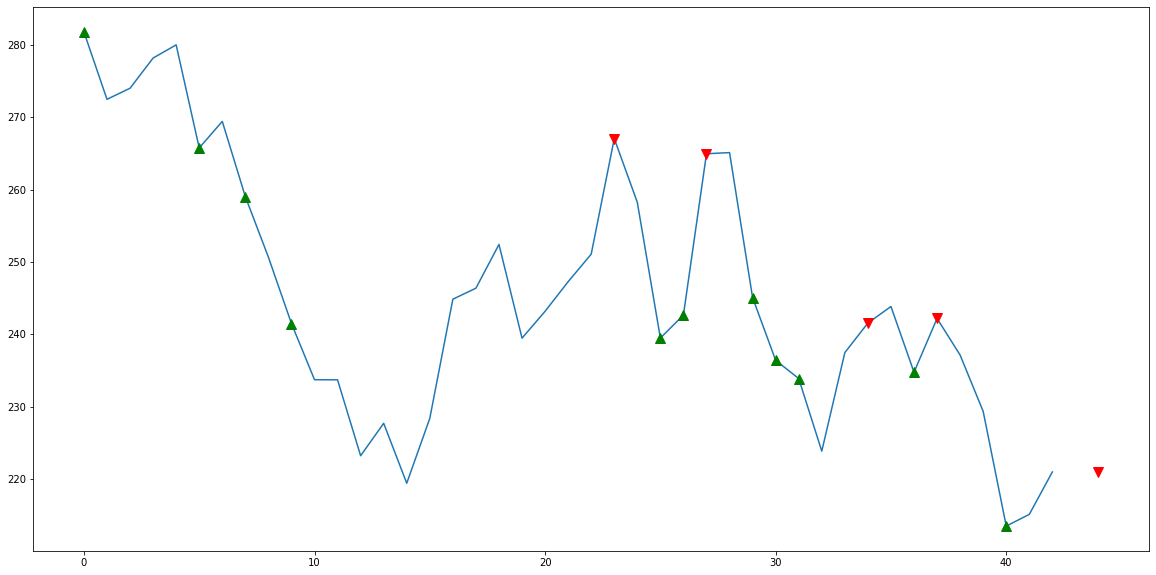

Starting Cash: 10000.0
Ending Cash:  10844.19
Net Gains:  8.44%

Stock: AMD
Actual Labeled Data Example Graphed for AMD for 0.4166666666666667 years


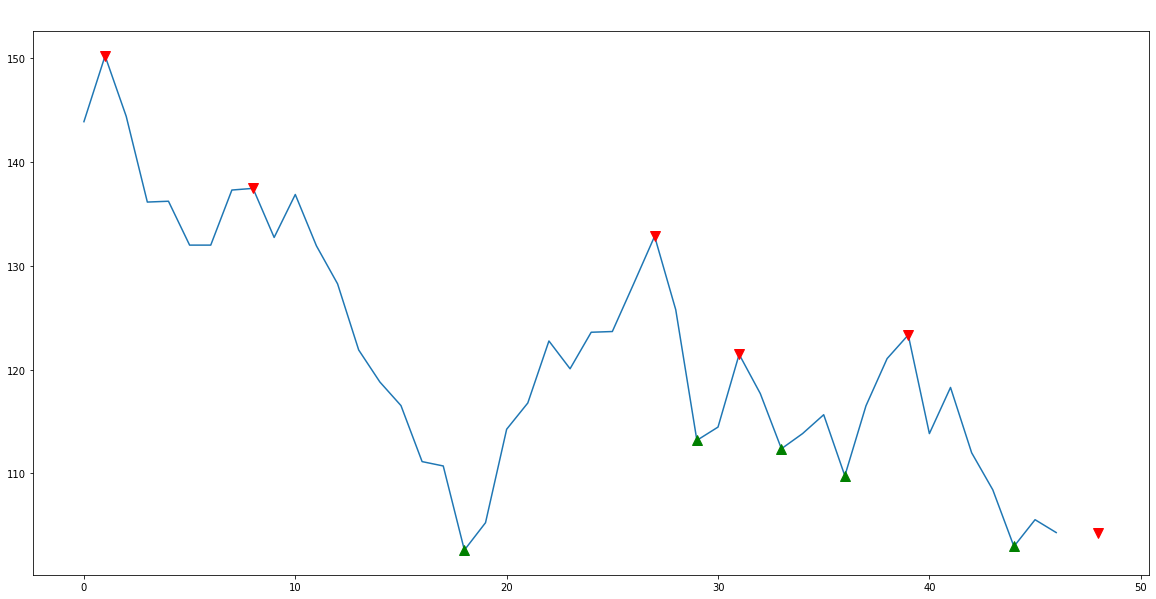

Generating Train DataFrame:
Shape of DataFrame: (139, 24)
Shape of DataFrame: (282, 24)
Shape of DataFrame: (425, 24)

Generating Test DataFrame:

Hyper-Parameter Settings:
 years of data for train/val: 1
       Stocks for Train: ['GOOG', 'MSFT', 'FB']
       Stock for Test: 'AMD'
       Fast Method = EMA
       Slow Method = SMA
       Fast EMA Beta: 0.6
       Slow EMA Beta: 0.2
       Fast SMA Value: 5
       Slow SMA Value: 15
       Feature Stacking: True


ML Ridge Classifier

f1 score train: 0.6625824914453315
f1 score test: 0.4280177187153931

Dimensions of Train Set: (425, 23)
Dimensions of Test Set: (43, 23)
Logistic Regression Predictions Graphed


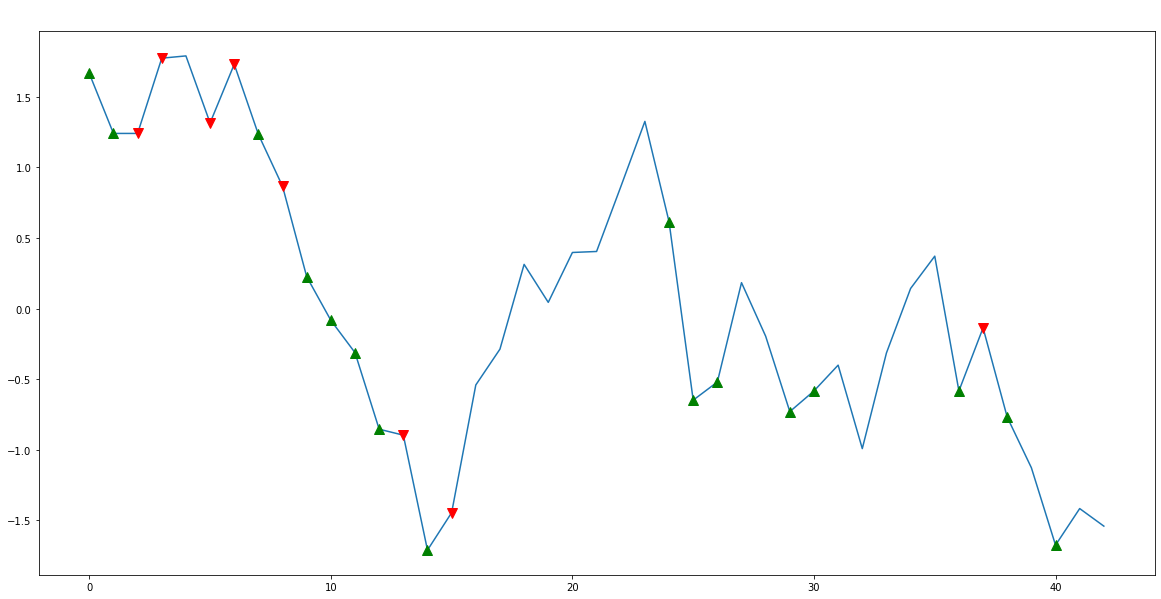

date: 2022-01-06
------buy------
Buy: 10.482272627174632 @ 136.23 = 1428.0
Available Cash: 8572.0
sum price: 1428.0

date: 2022-01-07
------buy------
Buy: 18.553030303030305 @ 132.0 = 2449.0
Available Cash: 6123.0
sum price: 3877.0

date: 2022-01-10
------sell------
date: 2022-01-11
Sell: 29.035302930204935 @ 137.31
Available Cash: 10109.83744534644

date: 2022-01-12
date: 2022-01-13
------sell------
date: 2022-01-14
------sell------
date: 2022-01-18
date: 2022-01-19
------sell------
date: 2022-01-20
------buy------
Buy: 11.846747067027648 @ 121.89 = 1444.0
Available Cash: 8665.83744534644
sum price: 1444.0

date: 2022-01-21
------sell------
date: 2022-01-24
------sell------
date: 2022-01-25
------sell------
date: 2022-01-26
------sell------
date: 2022-01-27
------sell------
date: 2022-01-28
------sell------
date: 2022-01-31
2022-02-01 Day Before Earnings... Force Sell
Sell: 11.846747067027648 @ 114.25
Available Cash: 10019.32829775435

date: 2022-02-03
------sell------
date: 2022-02-0

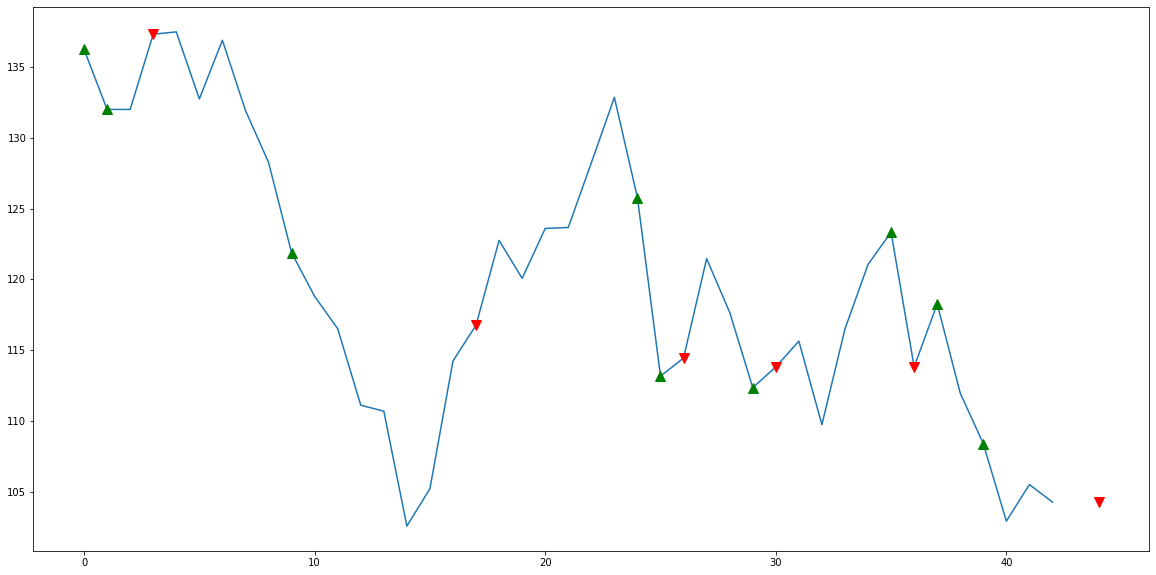

Starting Cash: 10000.0
Ending Cash:  10286.79
Net Gains:  2.87%

Average Net Gain:  4.33%
Min Net Gain:  0.91%
Max Net Gain:  8.44%


NameError: ignored

In [11]:
# ---------------------------------------------------------------------------------#

#                        Execute ML Based Buy/Sell Strategy                               #

# ---------------------------------------------------------------------------------#

stocks = ['AMZN', 'GOOGL', 'AAPL', 'NVDA', 'AMD']
alphas = [0.01, 0.00009, 0.0009, 0.0009, 0.0009]
debug = True

gains_percent = []
gains_money = []

for i in range(len(stocks)):
  # generate model for 
  print(f'Stock: {stocks[i]}')
  model = generate_ML_model(stocks[i], debug, alphas[i]) # 
  ML_strat = ML_Strategy(stocks[i], int(232*(5/12)), model, debug)
  gain, monies = ML_strat.run_backtest() # call backtest
  gains_percent.append(gain)
  gains_money.append(monies)

# print net gainz avg, min and max
print(f'Average Net Gain: {sum(gains_percent)/len(stocks) : .2f}%')
print(f'Min Net Gain: {min(gains_percent) : .2f}%')
print(f'Max Net Gain: {max(gains_percent) : .2f}%')

# update the tables with the appropriate gainz
for i,stock in enumerate(stocks):
  profit_percentages.loc['ML-LR', stock] = "{:.2f}%".format(gains_percent[i])
  profit_totals.loc['ML-LR', stock] = "${:.2f}".format(gains_money[i])
  
profit_percentages.loc['ML-LR','Total'] = "{:.2f}%".format(np.mean(gains_percent))
profit_totals.loc['ML-LR','Total'] = "${:.2f}".format(sum(gains_money))

In [12]:
# ---------------------------------------------------------------------------------#

#                          Definition for DL Neural Network                                   #

# ---------------------------------------------------------------------------------#
def DL_build_train(X_train, y_train, epochs=200, batch_size=8,
                   loss='sparse_categorical_crossentropy'):

    n_cols = X_train.shape[1]
    
    model_DL = Sequential()
    model_DL.add(L.Dense(100, activation='relu', input_shape=(n_cols,)))
    model_DL.add(L.Dense(300, activation='relu')) # , kernel_regularizer='l2'
    model_DL.add(L.Dropout(rate=.6))
    model_DL.add(L.Dense(800, activation='relu')) #, kernel_regularizer='l2'
    model_DL.add(L.Dense(500, activation='relu')) # , kernel_regularizer='l2'
    model_DL.add(L.Dense(3, activation=tensorflow.nn.softmax)) 

    model_DL.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
    model_DL.fit(X_train,y_train, batch_size=batch_size, epochs=epochs, verbose=0)
    
    return model_DL


# ---------------------------------------------------------------------------------#

#                          Definition for using model to predict                               #

# ---------------------------------------------------------------------------------#
def DL_predict(model, X_test, y_test):

    pred_test_DL = model.predict(X_test)
    classes_ = np.argmax(pred_test_DL, axis = 1)
    print(f'f1 score test: {f1(y_test, classes_, average="weighted")}')

    actual_data = X_test['Closing Prices']
    indices = actual_data.index
    
    #-----------------------------------------------------------------------------
    # Plot the Actual Values
    #-----------------------------------------------------------------------------
    print('Plotting Actual Values')
    plt.figure(figsize=(20,10))
    plt.plot(X_test['Closing Prices'].values)

    for i,pred in enumerate(y_test):
        x = indices[i][0] - indices[0][0]
        if pred == 1:
            plt.plot(x, actual_data.values[i], marker='^', markersize=10, markeredgecolor="green", markerfacecolor="green")
        elif pred == 2:
            plt.plot(x, actual_data.values[i], marker='v', markersize=10, markeredgecolor="red", markerfacecolor="red")
    plt.title('Actual Values', color='white', size=25)
    plt.show()

    #-----------------------------------------------------------------------------
    # Plot the Predicted Values
    #-----------------------------------------------------------------------------
    print('Plotting DL Predicted Values')
    plt.figure(figsize=(20,10))
    plt.plot(X_test['Closing Prices'].values)

    for i,pred in enumerate(classes_):
        x = indices[i][0] - indices[0][0]
        if pred == 1:
            plt.plot(x, actual_data.values[i], marker='^', markersize=10, markeredgecolor="green", markerfacecolor="green")
        elif pred == 2:
            plt.plot(x, actual_data.values[i], marker='v', markersize=10, markeredgecolor="red", markerfacecolor="red")
    plt.title('Predicted Values', color='white', size=25)
    plt.show()


# ---------------------------------------------------------------------------------#

#                   Definition for DL Based Buy/Sell Strategy                            #

# ---------------------------------------------------------------------------------#
class DL_Strategy(TradingStrategy):
 
  def __init__(self, STOCK, DAYS, debug=False):
    super().__init__(STOCK, DAYS)
    self.available_cash = self.BACKTEST_START_MONEY
    self.sum_price = 0
    self.count_buys = 0
    self.debug = debug
    self.actions = []

    self.yrs = 1
    self.fast_sma = 4 # active
    self.slow_sma = 7 
    self.fast_ema = 0.8 
    self.slow_ema = 0.76 # active
    self.fast_method = 'SMA'
    self.slow_method = 'EMA'
    self.stack = True
    self.epochs = 180

  '''
  Implement Live Trading
  '''
  def run_live():
    pass

  '''
  Generate start data using previous stock data predictions
  '''
  def generate_data_model(self):
    data = create_data(yrs=self.yrs, STOCK=self.STOCK, fast_method=self.fast_method, slow_method=self.slow_method,
                      fast_sma=self.fast_sma, slow_sma=self.slow_sma, fast_ema=self.fast_ema, slow_ema=self.slow_ema)
    if self.stack: data = feature_stack(data)

    self.X_backtest = data.loc[int((7/12)*data.shape[0]):]
    self.y_backtest = self.X_backtest.pop('labels')
    self.X_train = data.loc[:int((7/12)*data.shape[0])]
    self.y_train = self.X_train.pop('labels')

    self.mu, self.std = self.X_train.mean(), self.X_train.std() # get mean and std

    if self.debug: 
      print(f'mu shape: {self.mu.shape}')
      print(f'std shape: {self.std.shape}')

    self.X_train = (self.X_train-self.mu) / self.std # normalize train data
    self.X_backtest = (self.X_backtest-self.mu) / self.std # normalize test data

    self.generate_model() # call model function now that x,y train are set

  '''
  Generate and train DL model
  '''
  def generate_model(self):
    print('Building and Training Model on first 7/12 months')
    self.model = DL_build_train(self.X_train, self.y_train)
  
  '''
  Helper functions for backtesting
  '''
  def get_buy_quantity_backtest(self):
    if self.count_buys < 4:
      return int((self.available_cash / ((1/(self.count_buys+1)) * 7))) / self.current_stock_amount
    else: 
      return 0

  def reset_vars(self):
    #reset the counts upon selling -- ie sells all stock
    self.sum_price = 0
    self.current_num_stocks = 0
    self.count_buys = 0

  def sell_backtest(self, force=False):
    if force: 
      self.available_cash += self.current_stock_amount * self.current_num_stocks
      self.actions.append(2)
      if self.debug:
        print(f'Sell: {self.current_num_stocks} @ {self.current_stock_amount}')
        print(f'Available Cash: {self.available_cash}\n')
      self.reset_vars()
      return

    # only sell if greater than threshold sell limit factor * average price of the stocks bought    
    if (self.current_num_stocks * self.current_stock_amount) >= self.SELL_LIMIT_FACTOR * self.sum_price and self.current_num_stocks > 0:
      self.available_cash += self.current_stock_amount * self.current_num_stocks
      self.actions.append(2)
      if self.debug:
        print(f'Sell: {self.current_num_stocks} @ {self.current_stock_amount}')
        print(f'Available Cash: {self.available_cash}\n')
      self.reset_vars()
      return 
    
    self.actions.append(0) # if stock doesnt sell - append a 0 for hold

  def buy_backtest(self):
    # simulate buy by tracking quantity bought and available cash
    q = self.get_buy_quantity_backtest()
    if q > 0: 
      self.count_buys += 1
      self.actions.append(1)
    else: self.actions.append(0)
    self.available_cash -= q * self.current_stock_amount
    self.current_num_stocks += q
    if self.debug:
      print(f'Buy: {q} @ {self.current_stock_amount} = {q*self.current_stock_amount}')
      print(f'Available Cash: {self.available_cash}')

    # increment total sum 
    self.sum_price += self.current_stock_amount * q
    if self.debug:
      print(f'sum price: {self.sum_price}\n')

    if self.current_num_stocks == 0: self.reset_vars()


  def plot(self):
    actual_data = self.X_backtest['Closing Prices'] * self.std[0] + self.mu[0] # unnormalize
    indices = actual_data.index
    print(f'DNN Buy/Sell Actions Taken')
    plt.figure(figsize=(20,10))
    plt.plot(self.X_backtest['Closing Prices'].values * self.std[0] + self.mu[0])

    if self.debug:
      print(f'num actions: {len(self.actions)}')
      print(f'num indices: {len(indices)}')

    for i,action in enumerate(self.actions):
        if i >= len(indices): break
        x = indices[i][0] - indices[0][0]
        if action == 1:
            plt.plot(x, actual_data.values[i], marker='^', markersize=10, markeredgecolor="green", markerfacecolor="green")
        elif action == 2:
            plt.plot(x, actual_data.values[i], marker='v', markersize=10, markeredgecolor="red", markerfacecolor="red")
        #else:
          #  plt.plot(x, actual_data.values[i], marker='o', markersize=10, markeredgecolor="yellow", markerfacecolor="yellow")
    plt.show()

  
  '''
  Implement Backtesting
  '''
  def run_backtest(self):  
    # generate the data needed for backtesting and the trained model
    self.generate_data_model()

    if self.debug: print(self.dates)

    offset = 160 # dates are the amount of removed data points shifted

    if self.debug:
      print('samples in backtest: ', self.X_backtest.shape[0])
      print('len of dates: ', len(self.dates))
    
    # loop through data to do day by day predictions 
    for i in range(self.X_backtest.shape[0]):
      # if day before earnings -- force sell
      if self.dates[i+offset] == self.sell_earning_dates[self.STOCK][0] and self.current_num_stocks > 0:
        if self.debug: print(f'{self.dates[i+offset]} Day Before Earnings... Force Sell')
        self.sell_backtest(force=True)
      # if day of earnings -- hold else execute code below
      elif not self.dates[i+offset] == self.sell_earning_dates[self.STOCK][1]:
        
        if self.debug: print(f'date: {self.dates[i+offset]}')

        # get price at EOD
        self.current_stock_amount = self.X_backtest.iloc[i]['Closing Prices'] * self.std[0] + self.mu[0] # unnormalize

        #predict for that data point
        pred_action = self.model.predict(self.X_backtest.iloc[i].values.reshape(1,-1)) # normalized data
        pred_action = np.argmax(pred_action, axis = 1)
        
        #determine course of action
        if pred_action == 1: # buy
          if self.debug:
            print('------buy------')
          self.buy_backtest()
        elif pred_action == 2: # sell
          if self.debug:
            print('------sell------')
          self.sell_backtest()
        else: # hold
          if (self.current_num_stocks * self.current_stock_amount) >= self.SELL_LIMIT_FACTOR * self.sum_price and self.current_num_stocks > 0:
            self.sell_backtest()
          else: self.actions.append(0)
    
    if self.current_num_stocks > 0:
      if self.debug:
        print(f'\nNum stocks to fire sale at end: {self.current_num_stocks}')
      self.sell_backtest(force=True)

    self.net_gainz_percent = ((self.available_cash - self.BACKTEST_START_MONEY) / self.BACKTEST_START_MONEY ) * 100
    net_gainz_money = (self.available_cash - self.BACKTEST_START_MONEY)

    self.plot()

    print(f'Starting Cash: {self.BACKTEST_START_MONEY}\nEnding Cash: {self.available_cash : .2f}\nNet Gains: {self.net_gainz_percent : .2f}%\n')

    return self.net_gainz_percent, net_gainz_money

Stock: AMZN
mu shape: (23,)
std shape: (23,)
Building and Training Model on first 7/12 months
[datetime.date(2021, 4, 5), datetime.date(2021, 4, 6), datetime.date(2021, 4, 7), datetime.date(2021, 4, 8), datetime.date(2021, 4, 9), datetime.date(2021, 4, 12), datetime.date(2021, 4, 13), datetime.date(2021, 4, 14), datetime.date(2021, 4, 15), datetime.date(2021, 4, 16), datetime.date(2021, 4, 19), datetime.date(2021, 4, 20), datetime.date(2021, 4, 21), datetime.date(2021, 4, 22), datetime.date(2021, 4, 23), datetime.date(2021, 4, 26), datetime.date(2021, 4, 27), datetime.date(2021, 4, 28), datetime.date(2021, 4, 29), datetime.date(2021, 4, 30), datetime.date(2021, 5, 3), datetime.date(2021, 5, 4), datetime.date(2021, 5, 5), datetime.date(2021, 5, 6), datetime.date(2021, 5, 7), datetime.date(2021, 5, 10), datetime.date(2021, 5, 11), datetime.date(2021, 5, 12), datetime.date(2021, 5, 13), datetime.date(2021, 5, 14), datetime.date(2021, 5, 17), datetime.date(2021, 5, 18), datetime.date(2021,

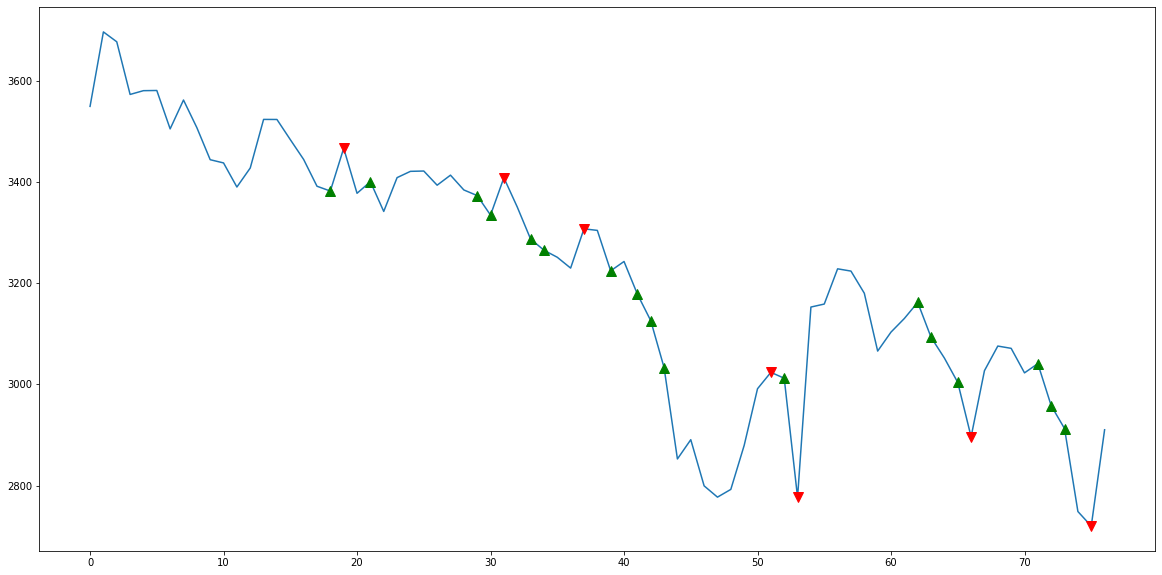

Starting Cash: 10000.0
Ending Cash:  10155.77
Net Gains:  1.56%

Stock: GOOGL
mu shape: (23,)
std shape: (23,)
Building and Training Model on first 7/12 months
[datetime.date(2021, 4, 5), datetime.date(2021, 4, 6), datetime.date(2021, 4, 7), datetime.date(2021, 4, 8), datetime.date(2021, 4, 9), datetime.date(2021, 4, 12), datetime.date(2021, 4, 13), datetime.date(2021, 4, 14), datetime.date(2021, 4, 15), datetime.date(2021, 4, 16), datetime.date(2021, 4, 19), datetime.date(2021, 4, 20), datetime.date(2021, 4, 21), datetime.date(2021, 4, 22), datetime.date(2021, 4, 23), datetime.date(2021, 4, 26), datetime.date(2021, 4, 27), datetime.date(2021, 4, 28), datetime.date(2021, 4, 29), datetime.date(2021, 4, 30), datetime.date(2021, 5, 3), datetime.date(2021, 5, 4), datetime.date(2021, 5, 5), datetime.date(2021, 5, 6), datetime.date(2021, 5, 7), datetime.date(2021, 5, 10), datetime.date(2021, 5, 11), datetime.date(2021, 5, 12), datetime.date(2021, 5, 13), datetime.date(2021, 5, 14), datetime.

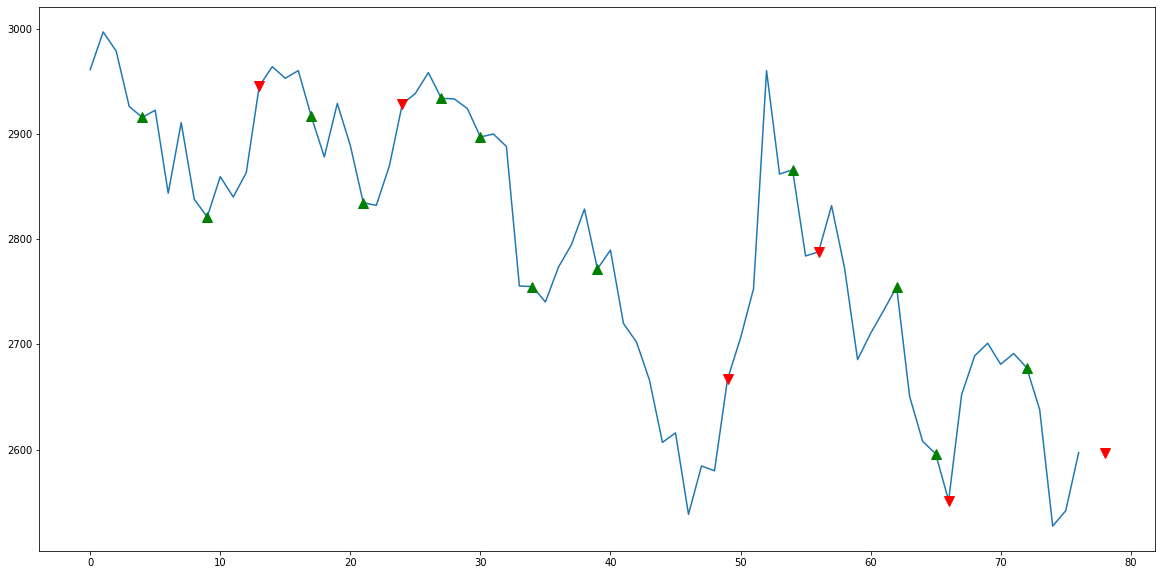

Starting Cash: 10000.0
Ending Cash:  9544.39
Net Gains: -4.56%

Stock: AAPL
mu shape: (23,)
std shape: (23,)
Building and Training Model on first 7/12 months
[datetime.date(2021, 4, 5), datetime.date(2021, 4, 6), datetime.date(2021, 4, 7), datetime.date(2021, 4, 8), datetime.date(2021, 4, 9), datetime.date(2021, 4, 12), datetime.date(2021, 4, 13), datetime.date(2021, 4, 14), datetime.date(2021, 4, 15), datetime.date(2021, 4, 16), datetime.date(2021, 4, 19), datetime.date(2021, 4, 20), datetime.date(2021, 4, 21), datetime.date(2021, 4, 22), datetime.date(2021, 4, 23), datetime.date(2021, 4, 26), datetime.date(2021, 4, 27), datetime.date(2021, 4, 28), datetime.date(2021, 4, 29), datetime.date(2021, 4, 30), datetime.date(2021, 5, 3), datetime.date(2021, 5, 4), datetime.date(2021, 5, 5), datetime.date(2021, 5, 6), datetime.date(2021, 5, 7), datetime.date(2021, 5, 10), datetime.date(2021, 5, 11), datetime.date(2021, 5, 12), datetime.date(2021, 5, 13), datetime.date(2021, 5, 14), datetime.da

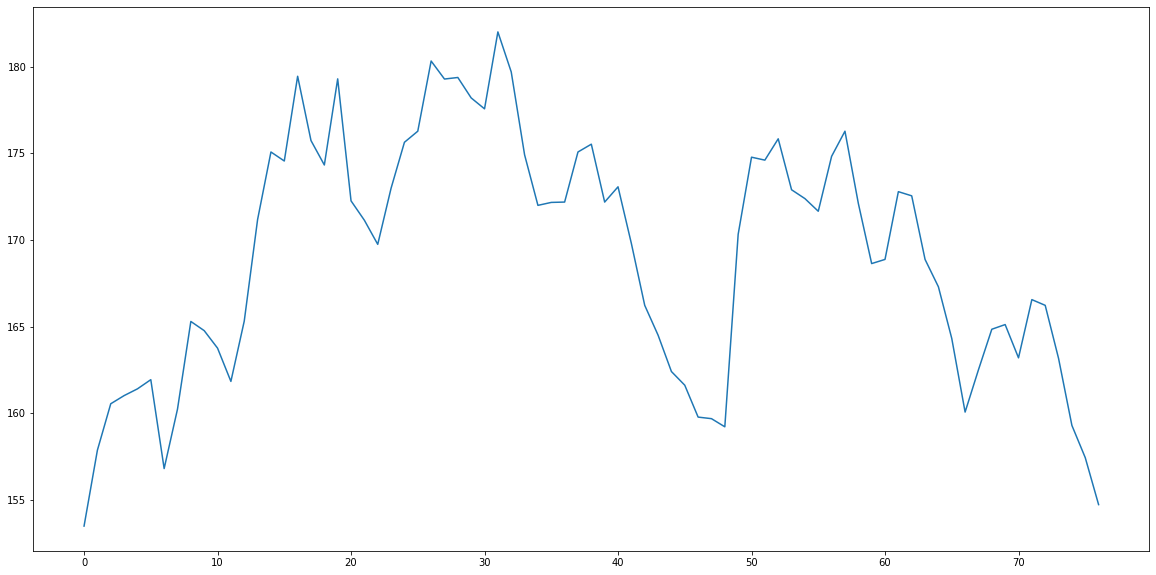

Starting Cash: 10000.0
Ending Cash:  10000.00
Net Gains:  0.00%

Stock: NVDA
mu shape: (23,)
std shape: (23,)
Building and Training Model on first 7/12 months
[datetime.date(2021, 4, 5), datetime.date(2021, 4, 6), datetime.date(2021, 4, 7), datetime.date(2021, 4, 8), datetime.date(2021, 4, 9), datetime.date(2021, 4, 12), datetime.date(2021, 4, 13), datetime.date(2021, 4, 14), datetime.date(2021, 4, 15), datetime.date(2021, 4, 16), datetime.date(2021, 4, 19), datetime.date(2021, 4, 20), datetime.date(2021, 4, 21), datetime.date(2021, 4, 22), datetime.date(2021, 4, 23), datetime.date(2021, 4, 26), datetime.date(2021, 4, 27), datetime.date(2021, 4, 28), datetime.date(2021, 4, 29), datetime.date(2021, 4, 30), datetime.date(2021, 5, 3), datetime.date(2021, 5, 4), datetime.date(2021, 5, 5), datetime.date(2021, 5, 6), datetime.date(2021, 5, 7), datetime.date(2021, 5, 10), datetime.date(2021, 5, 11), datetime.date(2021, 5, 12), datetime.date(2021, 5, 13), datetime.date(2021, 5, 14), datetime.d

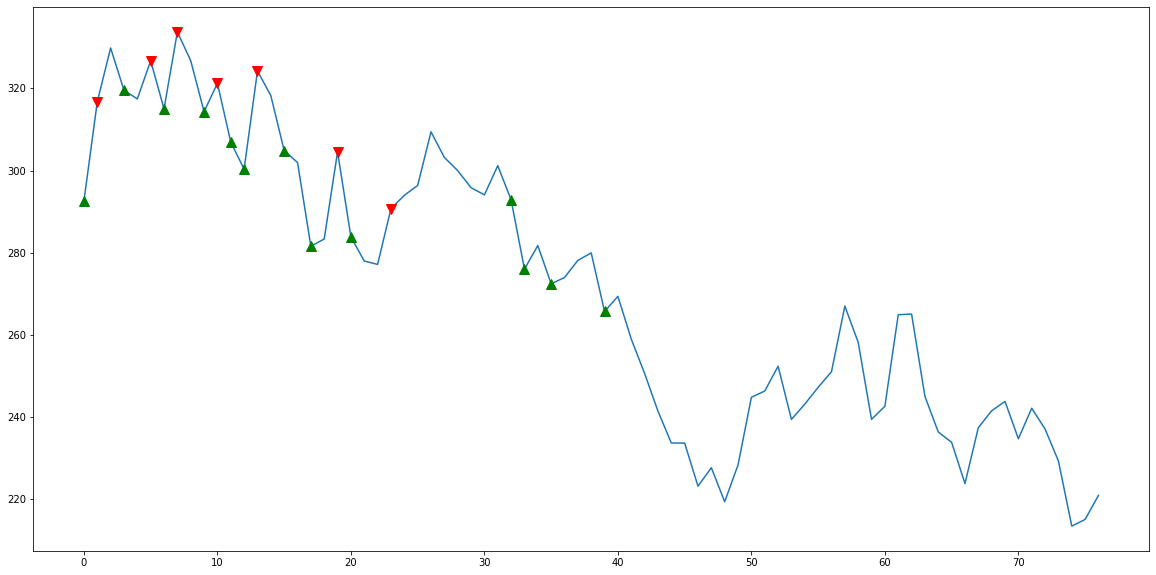

Starting Cash: 10000.0
Ending Cash:  8993.71
Net Gains: -10.06%

Stock: AMD
mu shape: (23,)
std shape: (23,)
Building and Training Model on first 7/12 months
[datetime.date(2021, 4, 5), datetime.date(2021, 4, 6), datetime.date(2021, 4, 7), datetime.date(2021, 4, 8), datetime.date(2021, 4, 9), datetime.date(2021, 4, 12), datetime.date(2021, 4, 13), datetime.date(2021, 4, 14), datetime.date(2021, 4, 15), datetime.date(2021, 4, 16), datetime.date(2021, 4, 19), datetime.date(2021, 4, 20), datetime.date(2021, 4, 21), datetime.date(2021, 4, 22), datetime.date(2021, 4, 23), datetime.date(2021, 4, 26), datetime.date(2021, 4, 27), datetime.date(2021, 4, 28), datetime.date(2021, 4, 29), datetime.date(2021, 4, 30), datetime.date(2021, 5, 3), datetime.date(2021, 5, 4), datetime.date(2021, 5, 5), datetime.date(2021, 5, 6), datetime.date(2021, 5, 7), datetime.date(2021, 5, 10), datetime.date(2021, 5, 11), datetime.date(2021, 5, 12), datetime.date(2021, 5, 13), datetime.date(2021, 5, 14), datetime.da

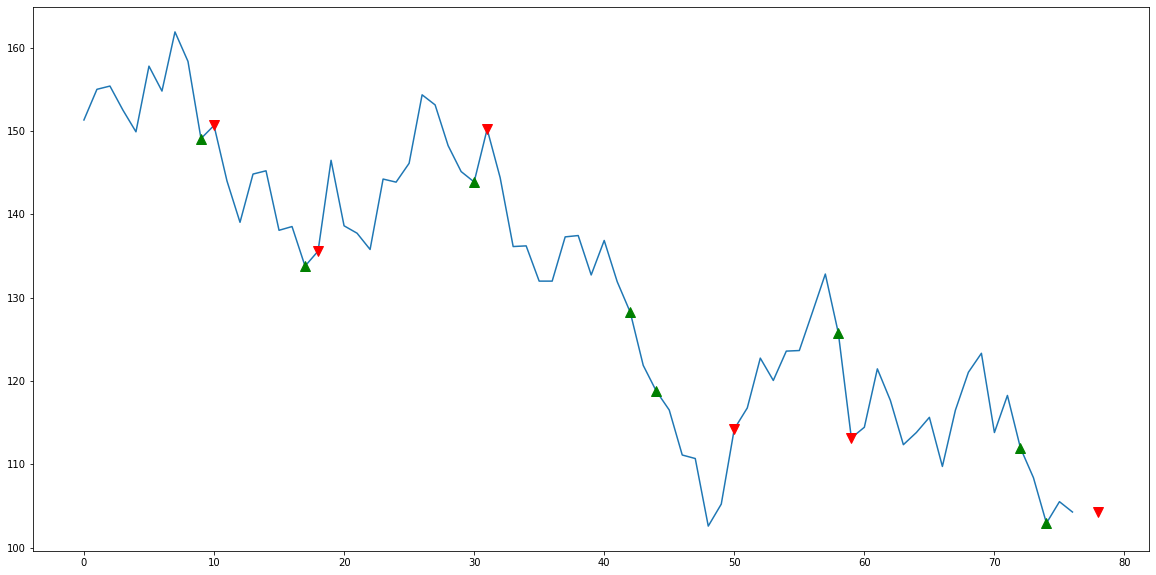

Starting Cash: 10000.0
Ending Cash:  9492.10
Net Gains: -5.08%

Average Net Gain: -3.63%
Min Net Gain: -10.06%
Max Net Gain:  1.56%


NameError: ignored

In [13]:
# ---------------------------------------------------------------------------------#

#                        Execute DL Based Buy/Sell Strategy                               #

# ---------------------------------------------------------------------------------#

stocks = ['AMZN', 'GOOGL', 'AAPL', 'NVDA', 'AMD']  
debug = True

gains_percent = []
gains_money = []

for i in range(len(stocks)):  
  print(f'Stock: {stocks[i]}')
  DL_strat = DL_Strategy(stocks[i], int(345), debug)
  gain, monies = DL_strat.run_backtest() # call backtest
  gains_percent.append(gain)
  gains_money.append(monies)

# print net gainz avg, min and max
print(f'Average Net Gain: {sum(gains_percent)/len(stocks) : .2f}%')
print(f'Min Net Gain: {min(gains_percent) : .2f}%')
print(f'Max Net Gain: {max(gains_percent) : .2f}%')

# update the tables with the appropriate gainz
for i,stock in enumerate(stocks):
  profit_percentages.loc['DNN', stock] = "{:.2f}%".format(gains_percent[i])
  profit_totals.loc['DNN', stock] = "${:.2f}".format(gains_money[i])
  
profit_percentages.loc['DNN','Total'] = "{:.2f}%".format(np.mean(gains_percent))
profit_totals.loc['DNN','Total'] = "${:.2f}".format(sum(gains_money))

In [ ]:
# display profit totals table
profit_totals

,AMZN,GOOGL,AAPL,NVDA,AMD,Total
SmaCross,$133.17,$-270.36,$13.05,$54.13,$12.87,$-57.14
EmaSmaCross,$2.36,$-293.50,$8.51,$49.59,$26.87,$-206.17
EmaCross,$124.62,$-38.25,$2.50,$-4.69,$3.22,$87.40
STL,$642.38,$155.60,$-1.78,$44.95,$-26.51,$814.64
ML-LR,$172.95,$-403.65,$601.41,$1138.99,$187.24,$1696.96
DNN,$333.40,$-23.39,$0.00,$605.66,$176.52,$1092.18


In [ ]:
# display profit percetages table
profit_percentages

,AMZN,GOOGL,AAPL,NVDA,AMD,Total
SmaCross,1.33%,-2.70%,0.13%,0.54%,0.13%,-0.11%
EmaSmaCross,0.02%,-2.94%,0.09%,0.50%,0.27%,-0.41%
EmaCross,1.25%,-0.38%,0.03%,-0.05%,0.03%,0.17%
STL,6.42%,1.56%,-0.02%,0.45%,-0.27%,1.63%
ML-LR,1.73%,-4.04%,6.01%,11.39%,1.87%,3.39%
DNN,3.33%,-0.23%,0.00%,6.06%,1.77%,2.18%
